# 01_research — Hull Tactical – Market Prediction
Notebook de pesquisa (EDA + CVs + tuning + ensembles). Para submissão rápida/reprodutível, use `02_submission`.

**Resumo rápido (métrica e alvo)**
- Alvo: `market_forward_excess_returns` (retorno de mercado em excesso); se ausente, gera a partir de `forward_returns - risk_free_rate`.
- Métrica oficial: Sharpe ajustado da competição, aplicado **só onde `is_scored == 1`**, com penalização de volatilidade e retorno vs. mercado.
- Allocation enviada ao host: `position = clip(1 + k * y_hat, 0, 2)`, que representa a fração de capital no mercado (0 = caixa, 1 = 100% comprado, 2 = alavancado em 2x); é essa série que o host usa para calcular o desempenho.

**Mini-exemplo numérico (3 dias)**
Retornos do mercado = [1.0%, -0.5%, 0.2%], `risk_free_rate = 0`, allocation constante = 1.0.
-> Retorno da estratégia = mercado (mesmos 3 valores).
-> `adjusted_sharpe_score` ≈ 5.99 para essa sequência, igual ao script oficial de avaliação (após anualização e penalidades).

## 0. Instalação (opcional)
Execute esta célula uma vez se faltar alguma lib.

In [39]:
!pip install -q lightgbm xgboost optuna kaggle seaborn matplotlib pandas numpy scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [40]:
# Imports e setup geral
import os
import json
import pathlib
import random
import zipfile

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

try:  # display helper for non-notebook runs
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover
    def display(obj):
        print(obj)

try:
    import xgboost as xgb

    HAS_XGB = True
except Exception:  # pragma: no cover
    HAS_XGB = False
try:
    from catboost import CatBoostRegressor

    HAS_CAT = True
except Exception:  # pragma: no cover
    HAS_CAT = False

SEED = 42
ALLOC_K = 1.0  # fator para mapear retorno previsto -> alocação (1 + k*y_hat, clip 0-2)
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

INTENTIONAL_DEFAULTS = {
    "clip_bounds": (-0.05, 0.05),  # clipping determinístico do excesso defasado
    "tanh_scale": 1.0,  # escala aplicada antes do tanh
    "zscore_window": 20,  # janela de std para o z-score defasado
    "zscore_clip": 5.0,  # limite para truncar o z-score
}
INTENTIONAL_CFG = dict(INTENTIONAL_DEFAULTS)

FEATURE_CFG_DEFAULT = {
    "winsor_quantile": 0.995,  # clipping bilateral para features muito skewed
    "skew_threshold": 3.0,  # aplica winsor se |skew| >= threshold
    "add_family_medians": True,
    "add_ratios": True,  # mean/std e mean-median por família
    "add_diffs": True,  # mean-std por família
    "use_extended_set": True,  # expõe o set E_fe_oriented
}
random.seed(SEED)
np.random.seed(SEED)

sns.set_theme()
pd.set_option("display.max_columns", 120)

# Hiperparâmetros de referência (melhores do Optuna)
BEST_PARAMS = {
    "learning_rate": 0.010897827897948612,
    "num_leaves": 42,
    "min_data_in_leaf": 388,
    "feature_fraction": 0.7079417306723327,
    "bagging_fraction": 0.6681010468585586,
    "bagging_freq": 10,
    "lambda_l1": 0.9244442250838115,
    "lambda_l2": 0.16637075433315218,
    "objective": "regression",
    "metric": "rmse",
    "seed": SEED,
    "verbosity": -1,
}

In [41]:
# Importa o pacote local (src/) para manter o notebook enxuto.
# (Funciona tanto rodando do root quanto de dentro de `notebooks/` e no Kaggle.)
import os
import sys
import subprocess
import shutil
from pathlib import Path

PROJECT_ROOT_OVERRIDE = ""  # ex.: "/content/<repo>" (Colab) ou "/kaggle/input/<dataset>/<repo>"

def _running_in_colab() -> bool:
    try:  # pragma: no cover
        import google.colab  # type: ignore  # noqa: F401

        return True
    except Exception:
        return False


AUTO_CLONE_REPO = _running_in_colab()  # Colab: clona o repo se `src/` não estiver disponível
REPO_GIT_URL = "https://github.com/Marcux777/Contest-Hull-Tactical-Market-Prediction.git"
REPO_CLONE_DIRNAME = "Contest-Hull-Tactical-Market-Prediction"

def _find_src_dir_for_package(package_name: str = "hull_tactical") -> Path | None:
    """Retorna o diretório `src/` que contém o pacote, se existir."""
    def _walk_find_root(root: Path, *, max_depth: int, max_dirs: int, skip_names: set[str]) -> Path | None:
        """Procura um root que contenha `src/<package_name>/__init__.py` com limites."""
        try:
            root_parts = root.resolve().parts
        except Exception:
            root_parts = root.parts

        visited = 0
        try:
            for dirpath, dirnames, _filenames in os.walk(root, topdown=True):
                visited += 1
                if visited > max_dirs:
                    break
                dirpath_p = Path(dirpath)
                try:
                    dir_parts = dirpath_p.resolve().parts
                except Exception:
                    dir_parts = dirpath_p.parts
                depth = len(dir_parts) - len(root_parts)
                if depth >= max_depth:
                    dirnames[:] = []
                    continue
                dirnames[:] = [d for d in dirnames if d not in skip_names]
                found = _check_root(dirpath_p)
                if found is not None:
                    return found
        except Exception:
            return None
        return None

    def _resolve_candidate_root(path_str: str) -> Path | None:
        if not path_str:
            return None
        try:
            cand = Path(path_str).expanduser().resolve()
        except Exception:
            return None
        return cand if cand.exists() else None

    def _check_root(root: Path) -> Path | None:
        try:
            init_file = root / "src" / package_name / "__init__.py"
            if init_file.exists():
                return init_file.parent.parent
            if root.name == "src":
                init_file = root / package_name / "__init__.py"
                if init_file.exists():
                    return root
            if root.name == package_name:
                init_file = root / "__init__.py"
                if init_file.exists():
                    return root.parent
        except Exception:
            return None
        return None

    root_override = _resolve_candidate_root(PROJECT_ROOT_OVERRIDE) or _resolve_candidate_root(
        os.environ.get("HULL_TACTICAL_PROJECT_ROOT", "")
    )
    if root_override is not None:
        found = _check_root(root_override)
        if found is not None:
            return found

    try:
        this_file = Path(__file__).resolve()
        for base in [this_file.parent] + list(this_file.parents):
            found = _check_root(base)
            if found is not None:
                return found
    except Exception:
        pass

    cwd = Path.cwd()
    for base in [cwd] + list(cwd.parents):
        found = _check_root(base)
        if found is not None:
            return found

    try:
        for child in cwd.iterdir():
            if child.is_dir():
                found = _check_root(child)
                if found is not None:
                    return found
    except Exception:
        pass

    content_root = Path("/content")
    if content_root.exists():
        try:
            for init_file in content_root.glob(f"*/src/{package_name}/__init__.py"):
                return init_file.parent.parent
        except Exception:
            pass
        found = _walk_find_root(
            content_root,
            max_depth=6,
            max_dirs=5000,
            skip_names={"drive", "__pycache__", ".ipynb_checkpoints", ".git", ".venv"},
        )
        if found is not None:
            return found

    drive_root = Path("/content/drive/MyDrive")
    if drive_root.exists():
        found = _walk_find_root(
            drive_root,
            max_depth=6,
            max_dirs=8000,
            skip_names={"__pycache__", ".ipynb_checkpoints", ".git", ".venv"},
        )
        if found is not None:
            return found

    kaggle_input = Path("/kaggle/input")
    if kaggle_input.exists():
        dataset_roots = []
        try:
            dataset_roots = [p for p in kaggle_input.iterdir() if p.is_dir()]
        except Exception:
            dataset_roots = []

        candidates: list[Path] = []
        for ds_root in sorted(dataset_roots):
            candidates.append(ds_root)
            try:
                children = [p for p in ds_root.iterdir() if p.is_dir()]
            except Exception:
                children = []
            candidates.extend(children)
            for child in children:
                try:
                    candidates.extend([p for p in child.iterdir() if p.is_dir()])
                except Exception:
                    continue

        for base in candidates:
            found = _check_root(base)
            if found is not None:
                return found
    return None


_src_dir = _find_src_dir_for_package("hull_tactical")
if _src_dir is None and AUTO_CLONE_REPO and Path("/content").exists():
    clone_dir = Path("/content") / REPO_CLONE_DIRNAME
    if shutil.which("git") is None:
        print("[import] git não encontrado; não foi possível clonar o repo automaticamente.")
    else:
        try:
            if not clone_dir.exists():
                subprocess.run(["git", "clone", "--depth", "1", REPO_GIT_URL, str(clone_dir)], check=True)
            PROJECT_ROOT_OVERRIDE = str(clone_dir)
            _src_dir = _find_src_dir_for_package("hull_tactical")
        except Exception as exc:  # pragma: no cover
            print(f"[import] Falha ao clonar repo automaticamente: {exc}")

if _src_dir is not None and str(_src_dir) not in sys.path:
    sys.path.insert(0, str(_src_dir))
    print(f"[import] Added to sys.path: {_src_dir}")
# Local/Colab: por padrão, use `data/` dentro do repo (se existir).
if _src_dir is not None:
    try:
        project_root_guess = Path(_src_dir).resolve().parent
        data_dir_guess = project_root_guess / "data"
        if data_dir_guess.exists():
            os.environ.setdefault("HT_DATA_DIR", str(data_dir_guess))
    except Exception:
        pass

try:
    from hull_tactical import competition as ht_comp
    from hull_tactical import io as ht_io
except ModuleNotFoundError as exc:  # pragma: no cover
    raise ModuleNotFoundError(
        "Não foi possível importar `hull_tactical`.\n"
        f"- cwd: {Path.cwd()}\n"
        f"- src_dir encontrado: {_src_dir}\n"
        "- Verifique se o diretório `src/hull_tactical/` está disponível no ambiente.\n"
        "- No Colab: clone/extraia o repo ou suba o diretório `src/`.\n"
        "- No Kaggle: adicione este repo como Dataset (ou copie `src/` para `/kaggle/working`).\n"
        "- Alternativa: defina `PROJECT_ROOT_OVERRIDE` ou env `HULL_TACTICAL_PROJECT_ROOT`."
    ) from exc

## 1. Dados (local/Colab)
Este notebook **não** baixa dados via Kaggle API/CLI (evita credenciais no código).

**Local (recomendado):**
- mantenha `data/raw/train.csv` e `data/raw/test.csv` no repo.
- o notebook tenta usar automaticamente `./data` do projeto via `HT_DATA_DIR`.

**Colab:**
- monte o Google Drive e copie a pasta `data/` (do seu ambiente local) para lá.
- depois, defina `DATA_DIR_OVERRIDE` apontando para a pasta `data/` no Drive.

In [42]:
RUNNING_IN_COLAB = _running_in_colab()
MOUNT_DRIVE = RUNNING_IN_COLAB
DATA_DIR_OVERRIDE = ""  # ex.: "/content/drive/MyDrive/hull-tactical/data"

if RUNNING_IN_COLAB and MOUNT_DRIVE:
    try:
        from google.colab import drive  # type: ignore

        drive.mount("/content/drive")
    except Exception as exc:  # pragma: no cover
        print("Aviso: não consegui montar o Drive automaticamente:", exc)

if DATA_DIR_OVERRIDE:
    os.environ["HT_DATA_DIR"] = DATA_DIR_OVERRIDE

print("HT_DATA_DIR:", os.environ.get("HT_DATA_DIR"))

HT_DATA_DIR: /home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data


## 3. Paths e verificação dos arquivos

In [43]:
COMPETITION = ht_io.COMPETITION_SLUG
try:
    paths = ht_io.ensure_local_data(
        ht_io.get_data_paths(),
        competition_slug=COMPETITION,
        download_if_missing=False,
    )
except FileNotFoundError as exc:
    msg = (
        f"{exc}\n\n"
        f"HT_DATA_DIR atual: {os.environ.get('HT_DATA_DIR')}\n\n"
        "Local: garanta `data/raw/train.csv` e `data/raw/test.csv` no repo (ou defina `HT_DATA_DIR`).\n"
        "Colab: coloque os arquivos em uma pasta do Drive e defina `DATA_DIR_OVERRIDE`/`HT_DATA_DIR`\n"
        "para essa pasta (ela deve conter `raw/train.csv` e `raw/test.csv`, ou `train.csv`/`test.csv`)."
    )
    raise FileNotFoundError(msg) from exc
DATA_DIR = paths.data_dir
SUBMISSION_DIR = paths.submissions_dir
RAW_DIR = paths.raw_dir
train_path = paths.train_path
test_path = paths.test_path
print("DATA_DIR escolhido:", DATA_DIR.resolve())
print("Usando data dir:", DATA_DIR.resolve())

DATA_DIR escolhido: /home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data
Usando data dir: /home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data


## 4. Carga e alvo

In [44]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print("train shape", train.shape, "test", test.shape)

# Normaliza colunas-chave e cria `target` para o pipeline.
_had_market_excess = "market_forward_excess_returns" in train.columns
train, test, cols = ht_comp.prepare_train_test(train, test, normalized_target_col="target")
if not _had_market_excess and "market_forward_excess_returns" in train.columns:
    print("Criei `market_forward_excess_returns` via forward_returns - risk_free_rate.")

TARGET_COL = cols.target_col
target_col = TARGET_COL  # compat: células antigas usam target_col
MARKET_COL = cols.market_col
RF_COL = cols.rf_col
IS_SCORED_COL = cols.is_scored_col
print(
    f"Colunas principais -> target: {TARGET_COL} (raw={cols.raw_target_col}) | "
    f"market: {MARKET_COL} | rf: {RF_COL} | is_scored: {IS_SCORED_COL or 'ausente'}"
)

display(train.head())

train shape (9021, 98) test (10, 99)
Colunas principais -> target: target (raw=market_forward_excess_returns) | market: forward_returns | rf: risk_free_rate | is_scored: is_scored


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns,target
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301,-0.012301


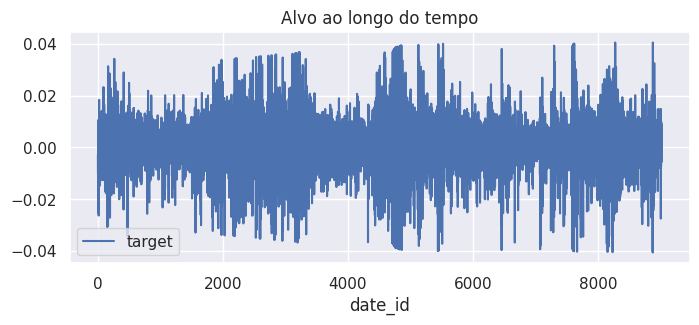

In [45]:
# Série temporal do alvo por date_id (se existir)
if "date_id" in train.columns:
    train.plot(x="date_id", y=TARGET_COL, kind="line", figsize=(8, 3), title="Alvo ao longo do tempo")
    plt.show()

**Nota (alvo e alocação):**
- Alvo fixo = retorno em excesso do mercado (`market_forward_excess_returns`) conforme definição oficial; fallback para `target`/`forward_returns` cria a coluna de excesso se necessário.
- Conversão `pred -> allocation`: `allocation = clip(1 + k * pred, 0, 2)` com `k` calibrado via Sharpe CV; clipping mantém a alocação entre 0 e 2.
- A avaliação usa a métrica oficial de Sharpe ajustado aplicada a essas alocações.

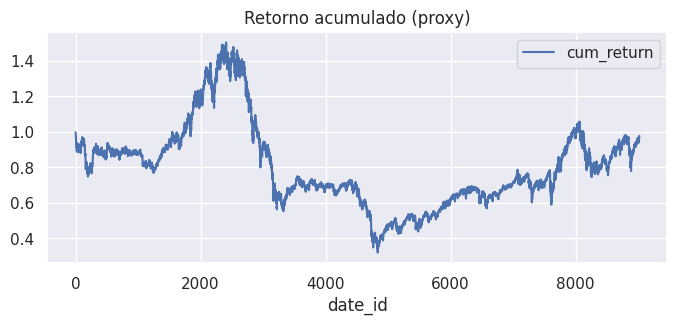

In [46]:
# Série temporal de retornos acumulados (simples) como sanity check
if "date_id" in train.columns:
    tmp = train.sort_values("date_id")[["date_id", TARGET_COL]].copy()
    tmp["cum_return"] = (1 + tmp[TARGET_COL].fillna(0)).cumprod()
    tmp.plot(x="date_id", y="cum_return", kind="line", figsize=(8, 3), title="Retorno acumulado (proxy)")
    plt.show()

## 5. Diagnóstico rápido

Top 10 colunas com mais NaN:
E7     0.772531
V10    0.670547
S3     0.635517
M1     0.614899
M13    0.614123
M14    0.614123
M6     0.559029
V9     0.503159
S12    0.392085
M5     0.363929
dtype: float64

Distribuição do alvo:
count    9021.000000
mean        0.000053
std         0.010558
min        -0.040582
25%        -0.004747
50%         0.000255
75%         0.005479
max         0.040551
Name: target, dtype: float64


Text(0.5, 1.0, 'Distribuição do alvo')

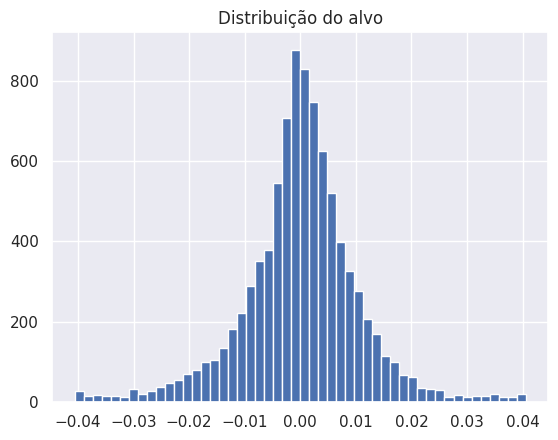

In [47]:
missing = train.isna().mean().sort_values(ascending=False)
print("Top 10 colunas com mais NaN:")
print(missing.head(10))

print("\nDistribuição do alvo:")
print(train[target_col].describe())
_ = train[target_col].hist(bins=50)
plt.title("Distribuição do alvo")

In [48]:
# Checagem rápida de is_scored (se existir)
if "is_scored" in train.columns:
    print("is_scored value counts:\n", train["is_scored"].value_counts())
    if "date_id" in train.columns:
        tmp = train.groupby(["date_id", "is_scored"]).size().unstack(fill_value=0)
        print("\nRegistros por date_id e is_scored (top 5):")
        print(tmp.head())

## 6. Correlação rápida e famílias de features

/tmp/ipykernel_95649/1717159853.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


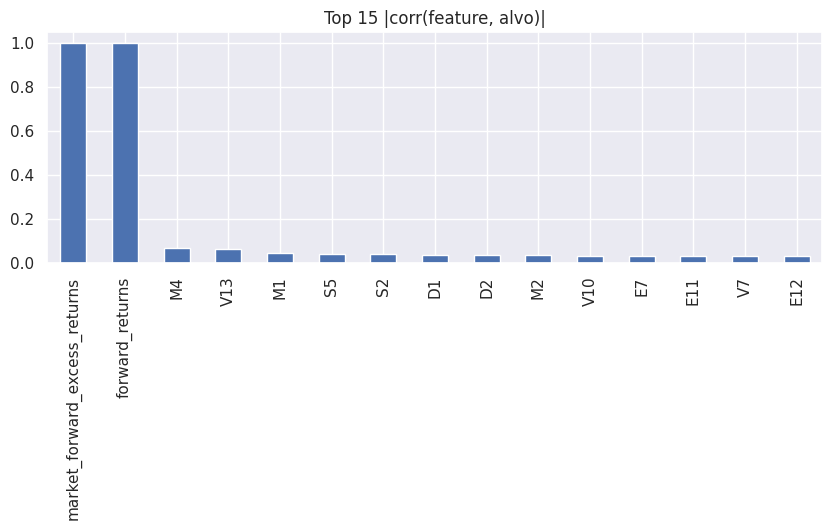

Top 15 correlações Spearman (alvo):


,spearman
market_forward_excess_returns,1.000000
forward_returns,0.999881
M1,0.053104
M4,-0.053103
V13,0.046438
S2,-0.044806
V10,0.043996
P5,-0.041314
S5,0.039138
V7,0.036789


In [49]:
# Top correlações absolutas com o alvo (informam direção das features mais úteis)
numeric_cols = train.select_dtypes(include=[np.number]).columns
feature_pool = [c for c in numeric_cols if c not in {target_col, "row_id"}]
top_corr = train[feature_pool].corrwith(train[target_col]).abs().sort_values(ascending=False).head(15)
top_corr.plot(kind="bar", figsize=(10, 3), title="Top 15 |corr(feature, alvo)|")
plt.tight_layout()
plt.show()

# Spearman (ordem por sinal de monotonicidade)
top_spearman = (
    train[feature_pool]
    .corrwith(train[target_col], method="spearman")
    .sort_values(key=lambda s: s.abs(), ascending=False)
    .head(15)
)
print("Top 15 correlações Spearman (alvo):")
display(top_spearman.to_frame("spearman"))

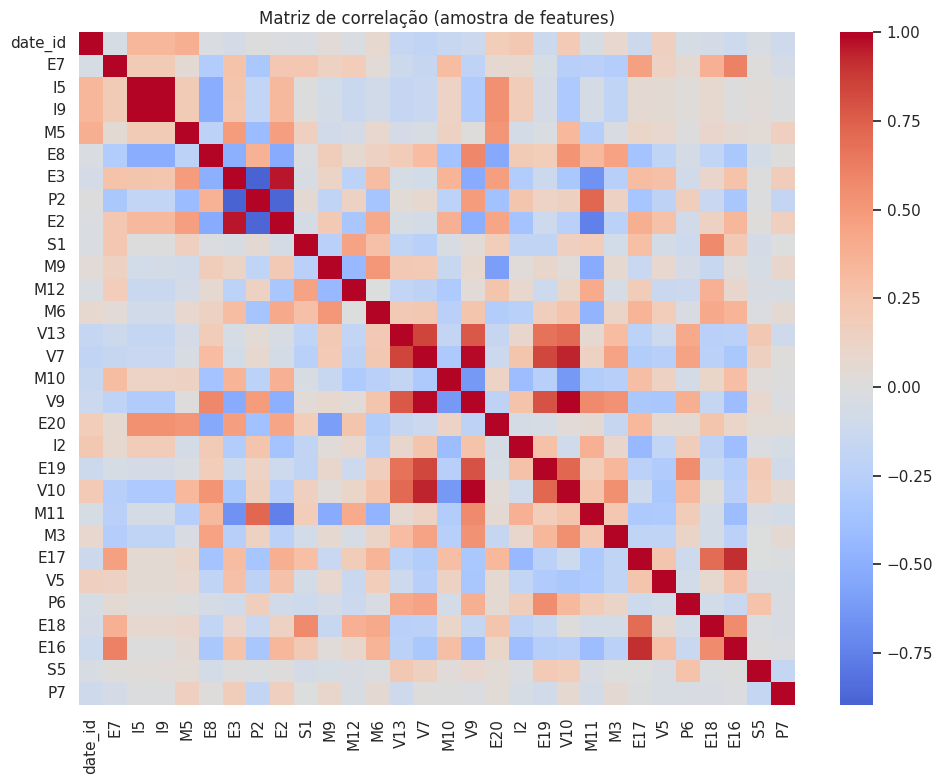

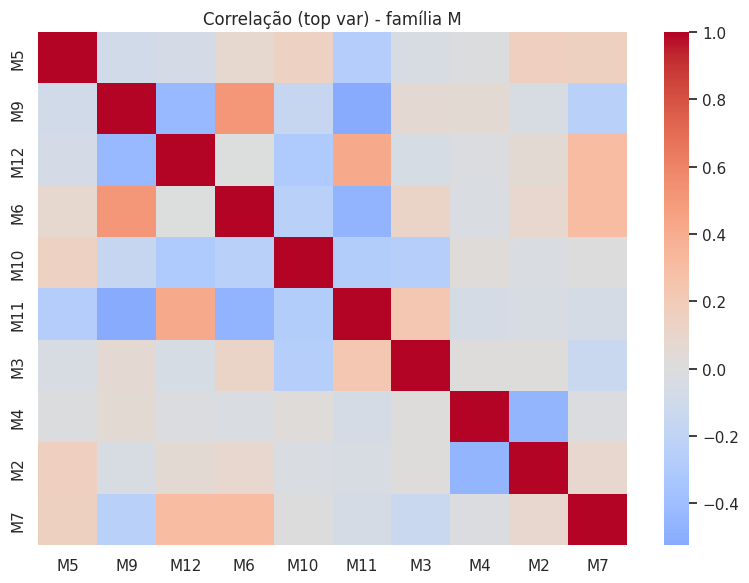

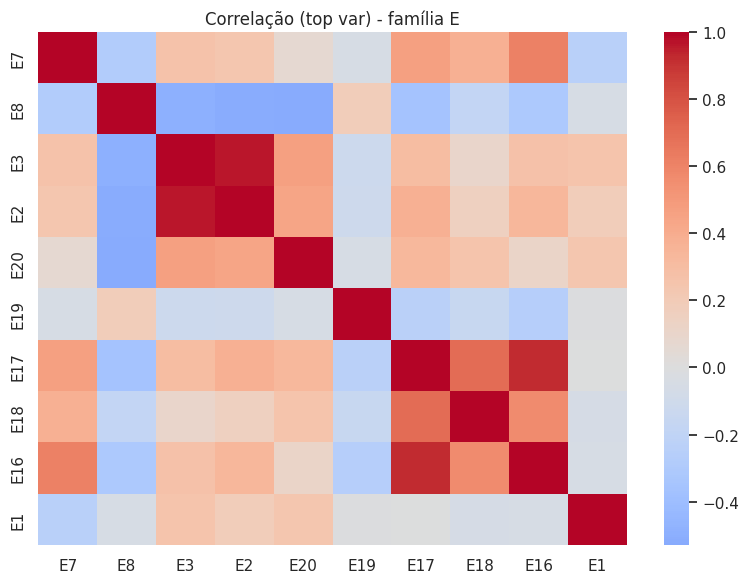

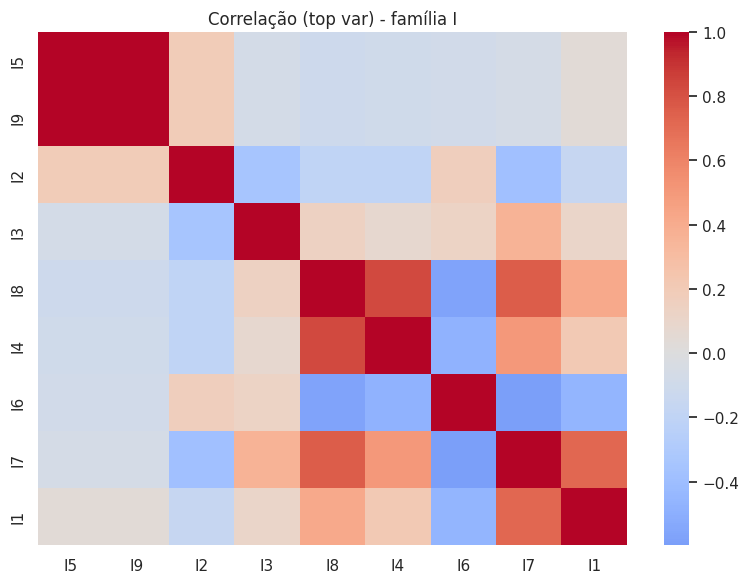

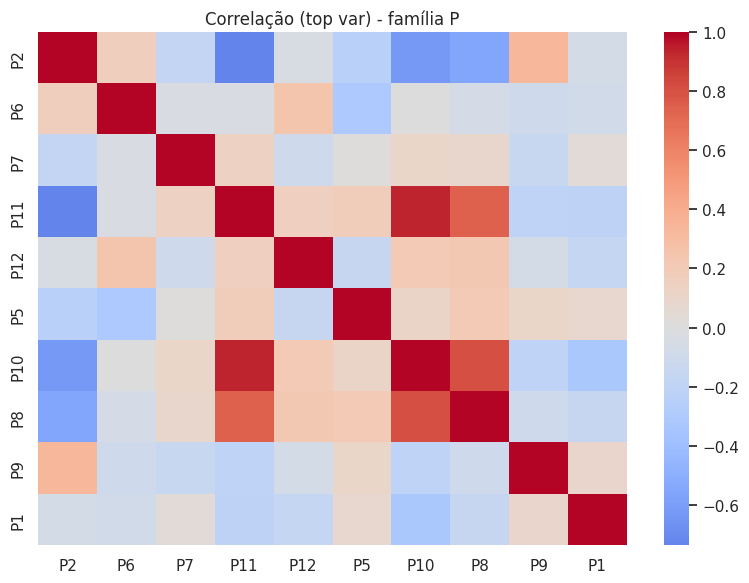

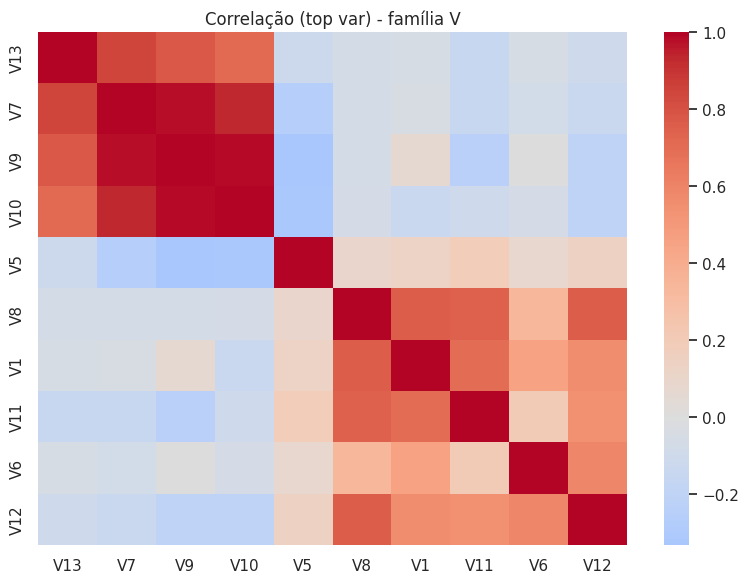

In [50]:
# Colinearidade: matriz de correlação (top 30 por variância) para observar redundância
var_sorted = train[feature_pool].var().sort_values(ascending=False)
sample_cols = var_sorted.head(min(30, len(var_sorted))).index.tolist()
corr_sample = train[sample_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sample, cmap="coolwarm", center=0)
plt.title("Matriz de correlação (amostra de features)")
plt.tight_layout()
plt.show()

# Heatmaps menores por família (top 10 por variância em cada grupo)
families = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
for fam, cols in families.items():
    if len(cols) < 3:
        continue
    var_sorted_fam = train[cols].var().sort_values(ascending=False)
    fam_cols = var_sorted_fam.head(min(10, len(var_sorted_fam))).index.tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(train[fam_cols].corr(), cmap="coolwarm", center=0)
    plt.title(f"Correlação (top var) - família {fam}")
    plt.tight_layout()
    plt.show()

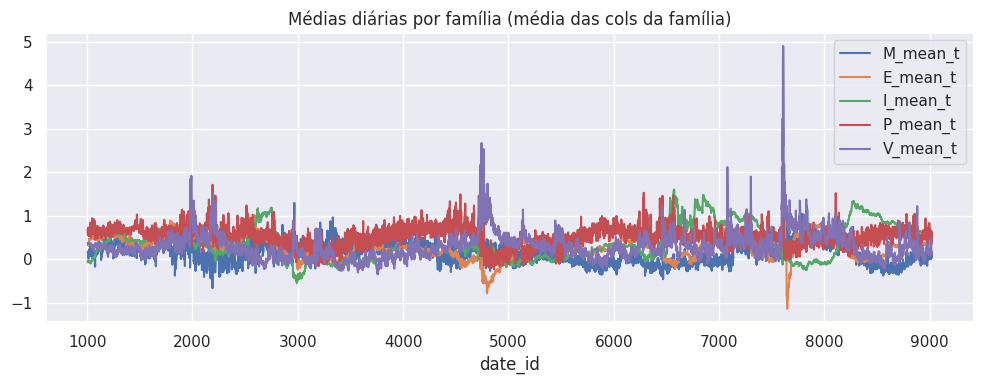

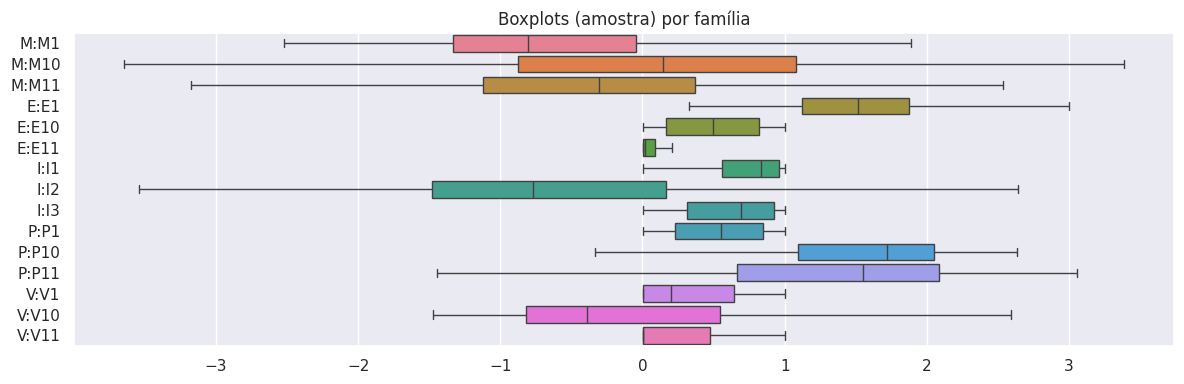

In [51]:
# Distribuições e cortes por família ao longo do tempo (médias diárias)
fams = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
if "date_id" in train.columns:
    fam_means = {}
    for fam, cols in fams.items():
        if not cols:
            continue
        fam_means[f"{fam}_mean_t"] = train.groupby("date_id")[cols].mean().mean(axis=1)
    if fam_means:
        fam_df = pd.DataFrame(fam_means)
        fam_df.plot(figsize=(10, 4), title="Médias diárias por família (média das cols da família)")
        plt.tight_layout()
        plt.show()
    # Boxplot por família (amostra) para ver dispersão
    box_data = []
    for fam, cols in fams.items():
        take = cols[:3]
        for col in take:
            box_data.append(train[col].dropna().sample(min(5000, train[col].dropna().shape[0]), random_state=SEED).rename(f"{fam}:{col}"))
    if box_data:
        combined = pd.concat(box_data, axis=1)
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=combined, orient="h", showfliers=False)
        plt.title("Boxplots (amostra) por família")
        plt.tight_layout()
        plt.show()

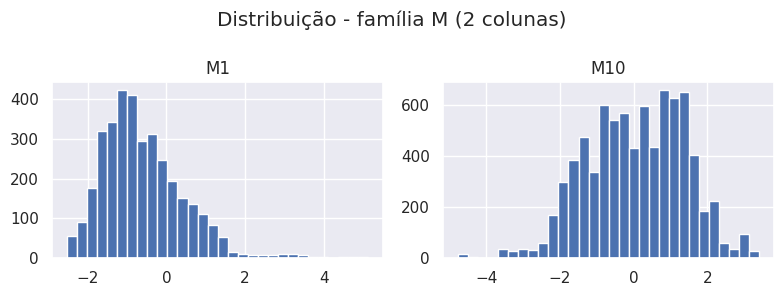

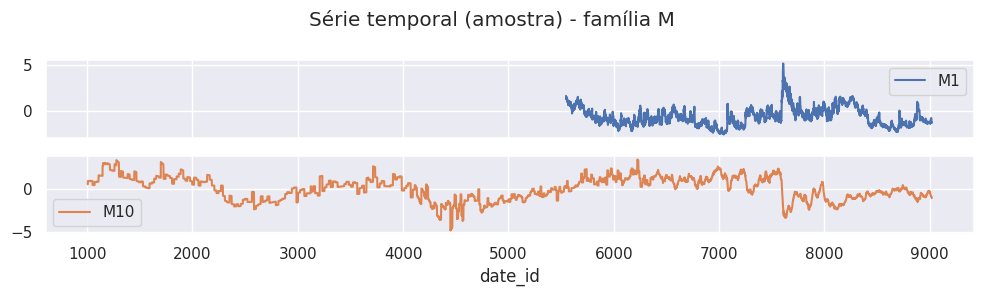

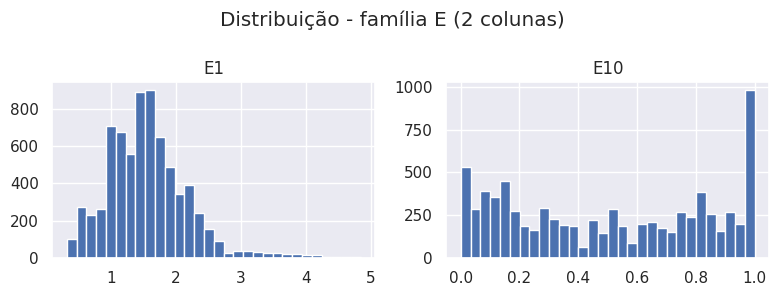

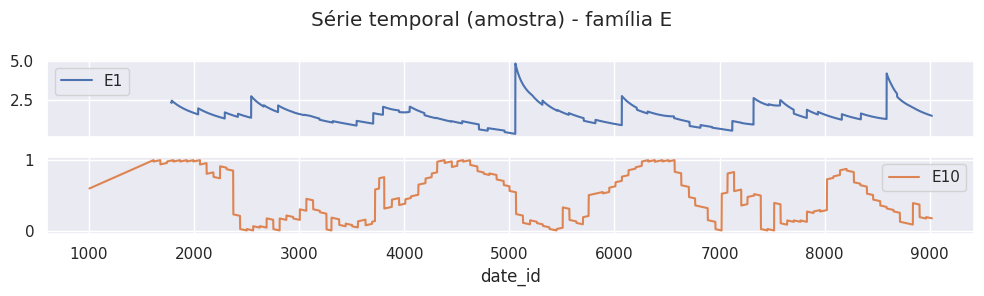

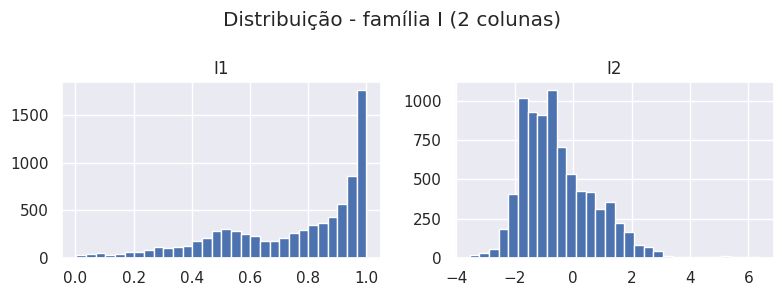

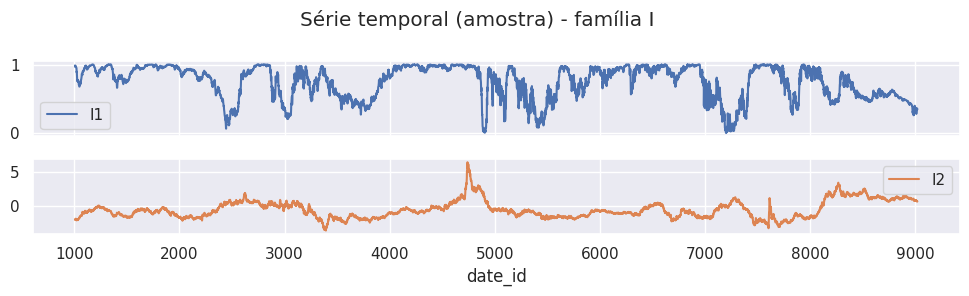

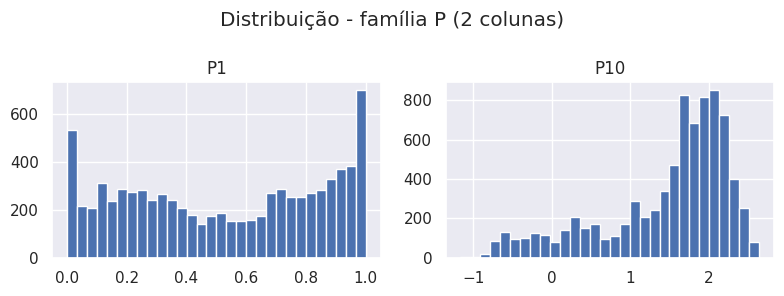

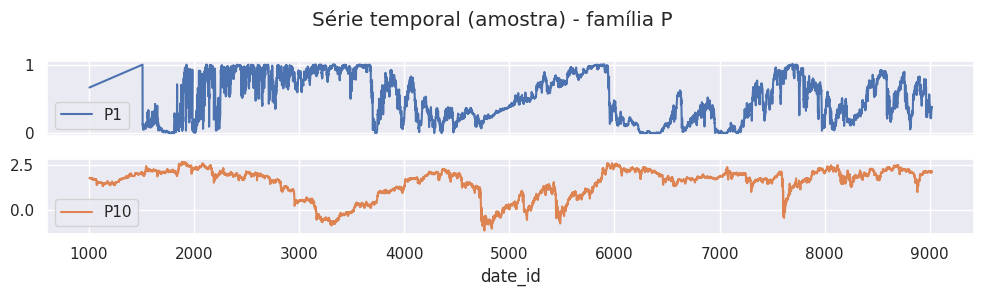

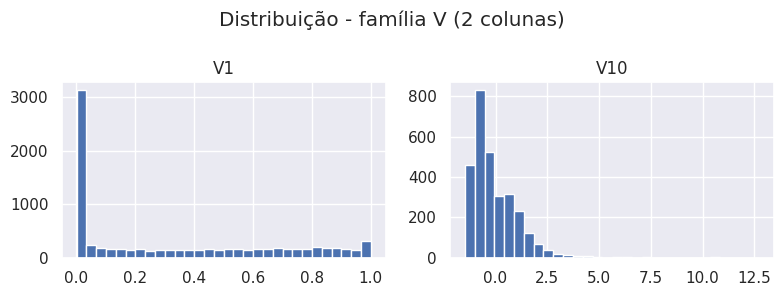

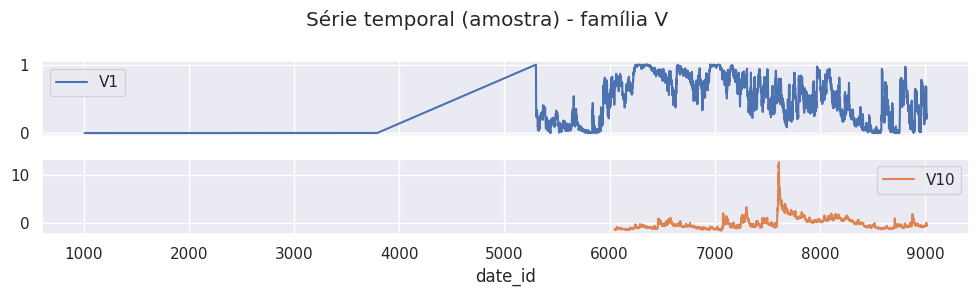

In [52]:
# Amostra de colunas por família (M/E/I/P/V): histograma rápido para escala/dispersão
families = {g: [c for c in feature_pool if c.startswith(g)] for g in ["M", "E", "I", "P", "V"]}
for fam, cols in families.items():
    take = cols[:2]
    if not take:
        continue
    train[take].hist(bins=30, figsize=(8, 3))
    plt.suptitle(f"Distribuição - família {fam} (2 colunas)")
    plt.tight_layout()
    plt.show()
    if "date_id" in train.columns:
        tmp = train.sort_values("date_id")[["date_id"] + take]
        tmp.set_index("date_id")[take].plot(subplots=True, figsize=(10, 3), title=f"Série temporal (amostra) - família {fam}")
        plt.tight_layout()
        plt.show()

### Comparações train vs test e regimes

Médias/volatilidades por família (train vs test):


split,test,train
family,,
E,0.353741,0.271369
I,0.485636,0.387901
M,0.071712,0.049919
P,0.571983,0.508921
V,0.256438,0.281485


split,test,train
family,,
E,0.034466,0.752711
I,0.021977,0.699944
M,0.167596,0.888994
P,0.227315,0.774633
V,0.095981,0.682188


<Figure size 800x300 with 0 Axes>

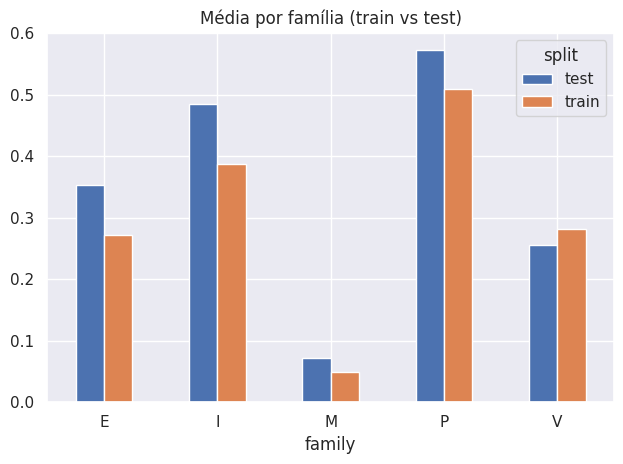

<Figure size 800x300 with 0 Axes>

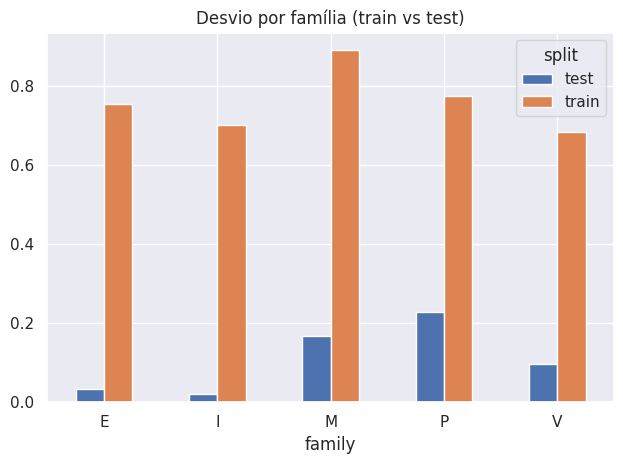

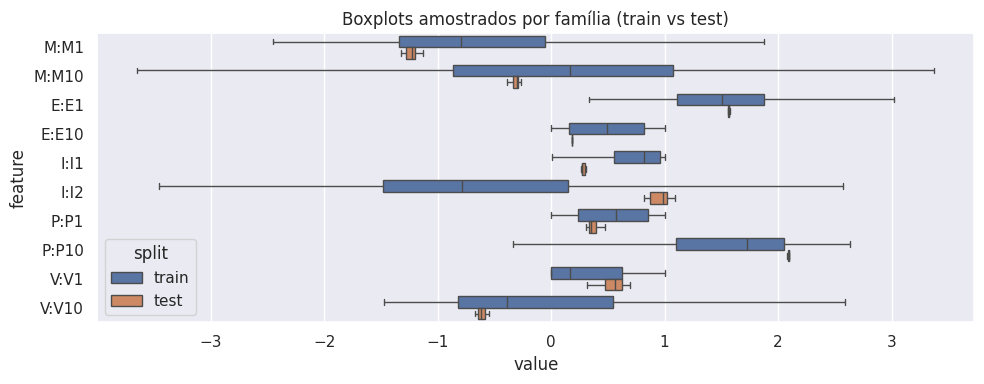

In [53]:
fam_stats_rows = []
for split_name, df_split in [("train", train), ("test", test)]:
    for fam, cols in families.items():
        cols_use = [c for c in cols if c in df_split.columns]
        if not cols_use:
            continue
        fam_stats_rows.append(
            {
                "split": split_name,
                "family": fam,
                "mean": float(df_split[cols_use].mean().mean()),
                "std": float(df_split[cols_use].std(ddof=0).mean()),
            }
        )
fam_stats_df = pd.DataFrame(fam_stats_rows)
if not fam_stats_df.empty:
    print("Médias/volatilidades por família (train vs test):")
    display(fam_stats_df.pivot(index="family", columns="split", values="mean"))
    display(fam_stats_df.pivot(index="family", columns="split", values="std"))
    plt.figure(figsize=(8, 3))
    fam_stats_df.pivot(index="family", columns="split", values="mean").plot(kind="bar", rot=0, title="Média por família (train vs test)")
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 3))
    fam_stats_df.pivot(index="family", columns="split", values="std").plot(kind="bar", rot=0, title="Desvio por família (train vs test)")
    plt.tight_layout()
    plt.show()

# Boxplots comparando train/test (amostra) para 2 cols por família
box_rows = []
for split_name, df_split in [("train", train), ("test", test)]:
    for fam, cols in families.items():
        take = [c for c in cols if c in df_split.columns][:2]
        for col in take:
            series = df_split[col].dropna()
            if series.empty:
                continue
            sample = series.sample(min(3000, len(series)), random_state=SEED)
            box_rows.append(pd.DataFrame({"value": sample, "feature": f"{fam}:{col}", "split": split_name}))
if box_rows:
    box_df = pd.concat(box_rows, axis=0)
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=box_df, x="value", y="feature", hue="split", showfliers=False)
    plt.title("Boxplots amostrados por família (train vs test)")
    plt.tight_layout()
    plt.show()

# Distribuição de retornos defasados do mercado e features de regime
lag_col = "lagged_market_forward_excess_returns" if "lagged_market_forward_excess_returns" in train.columns else None
if lag_col:
    plt.figure(figsize=(8, 3))
    train[lag_col].hist(bins=40, alpha=0.6, label="train")
    if lag_col in test.columns:
        test[lag_col].hist(bins=40, alpha=0.6, label="test")
    plt.title(f"Distribuição {lag_col} (train/test)")
    plt.legend()
    plt.tight_layout()
    plt.show()
for reg_col in ["regime_std_20", "regime_high_vol"]:
    if reg_col in train.columns:
        plt.figure(figsize=(8, 3))
        train[reg_col].hist(bins=40, alpha=0.6, label=f"{reg_col} train")
        if reg_col in test.columns:
            test[reg_col].hist(bins=40, alpha=0.6, label=f"{reg_col} test")
        plt.title(f"Distribuição {reg_col} (train/test)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Impacto de regime_high_vol (quando existir)
if "regime_high_vol" in train.columns:
    grp = train.groupby(train["regime_high_vol"].fillna(0))[[target_col]]
    impact_df = grp.agg(["mean", "std"]).rename_axis("regime_high_vol")
    print("Alvo por regime_high_vol (train):")
    display(impact_df)

**Insights EDA (anotar)**
- Famílias com maiores médias/vol no train vs test; olhar barras acima para detectar shifts.
- Features mais correlacionadas (Pearson/Spearman) e se mantêm estáveis nos boxplots train/test.
- Regime_high_vol e lagged_market_forward_excess_returns: checar distribuição e impacto no Sharpe/target; ajustar features/intencional se houver drift.

## 7. Preparação de features
As funções de engenharia e preprocessamento foram movidas para `src/hull_tactical/features.py`
e são importadas mais abaixo (célula de materialização do pacote).

In [54]:
# Helpers para materializar módulos (Kaggle/offline)
import sys
import textwrap
from pathlib import Path


def materialize_package(src_dir: Path, dest_dir: Path) -> None:
    """Copia um pacote inteiro para o working dir (útil no Kaggle offline)."""
    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)
    print(f"Pacote {dest_dir} materializado de {src_dir}")


# Materializa o pacote hull_tactical (features + models) para uso no notebook/Kaggle.
# Robustez extra: tenta importar primeiro; se falhar, procura em diretórios parentes.
PACKAGE_DEST = Path("hull_tactical")

def find_package_src(max_up=3) -> Path | None:
    candidates = []
    cwd = Path.cwd()
    for base in [cwd] + list(cwd.parents)[:max_up]:
        candidates.append(base / "src" / "hull_tactical")
    for cand in candidates:
        try:
            if cand.exists():
                return cand
        except Exception:
            continue
    return None

try:
    import hull_tactical as _ht  # type: ignore
    PACKAGE_AVAILABLE = True
    print("Pacote hull_tactical já disponível; pulando materialização.")
except Exception:
    PACKAGE_AVAILABLE = False

if not PACKAGE_AVAILABLE:
    PACKAGE_SRC = find_package_src()
    if PACKAGE_SRC is None:
        raise FileNotFoundError("src/hull_tactical não encontrado; garanta que o repo está completo ou adicione o pacote ao ambiente.")
    materialize_package(PACKAGE_SRC, PACKAGE_DEST)

sys.path.insert(0, '.')
from hull_tactical.features import *  # noqa: F401,F403

from hull_tactical.allocation import AllocationConfig, apply_allocation_strategy

import hull_tactical.models as hm
from hull_tactical import pipeline
from hull_tactical.models import (  # noqa: F401,F403
    evaluate_baselines,
    constant_allocation_cv,
    time_cv_lightgbm_fitref,
    make_time_splits,
    compute_strategy_returns,
    map_return_to_alloc,
    adjusted_sharpe_score,
    optimize_allocation_scale,
    time_cv_lightgbm,
    sanity_shuffle_test,
    clipping_sensitivity,
    summarize_cv_metrics,
    make_sample_weight,
    time_cv_lightgbm_weighted,
    stability_check,
    run_cv_preds,
    calibrate_k_from_cv_preds,
    calibrate_k_alpha_from_cv_preds,
    expanding_holdout_eval,
    choose_scored_strategy,
    compute_sharpe_weights,
    blend_and_eval,
    train_full_and_predict_returns,
    train_full_and_predict_model,
    prepare_train_test_frames,
    add_exp_log,
    set_data_columns,
)

hm.set_data_columns(MARKET_COL, RF_COL, IS_SCORED_COL)
hm.INTENTIONAL_CFG = INTENTIONAL_CFG
hm.FEATURE_CFG_DEFAULT = FEATURE_CFG_DEFAULT
hm.BEST_PARAMS = BEST_PARAMS
hm.ALLOC_K = ALLOC_K
hm.MIN_INVESTMENT = MIN_INVESTMENT
hm.MAX_INVESTMENT = MAX_INVESTMENT

# Pipeline de alto nível (mantém notebook alinhado ao src/hull_tactical)
PIPELINE_FEATURE_SET = "D_intentional"
PIPELINE_CFG = hm.default_config()


def run_pipeline_allocations(feature_set: str = PIPELINE_FEATURE_SET, cfg=None):
    cfg_use = cfg or PIPELINE_CFG
    return pipeline.train_pipeline(
        df_train=train,
        df_test=test,
        feature_set=feature_set,
        cfg=cfg_use,
    )

Pacote hull_tactical já disponível; pulando materialização.


## 7. EDA focada na métrica (Sharpe)
- Série do alvo e volatilidade rolling para achar regimes.
- Baseline de alocação constante (posição=1) usando a métrica oficial.
- Buracos de dados por data_id e por família de features, além de colinearidade intra-família.

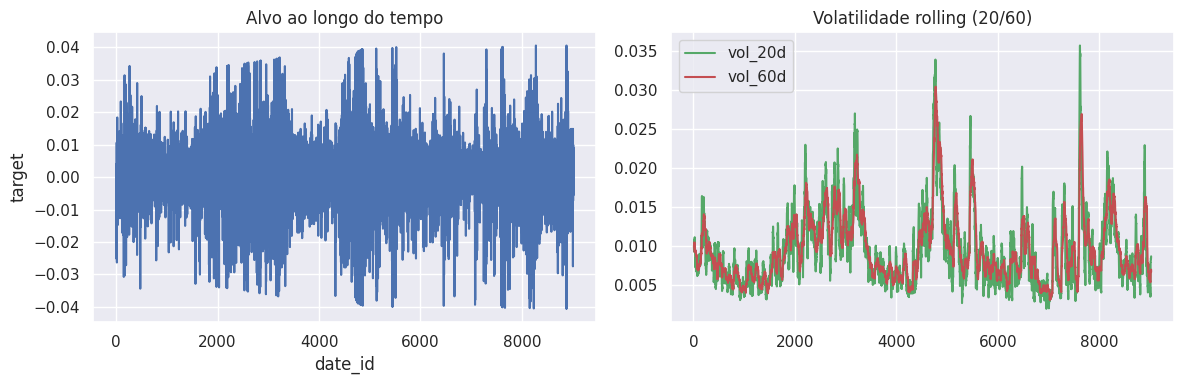

Sharpe ajustado (alloc=1 constante): 0.4651 | vol estratégia=16.7323


/tmp/ipykernel_95649/2441485710.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_by_date = train.groupby("date_id").apply(lambda df: df.isna().mean().mean())


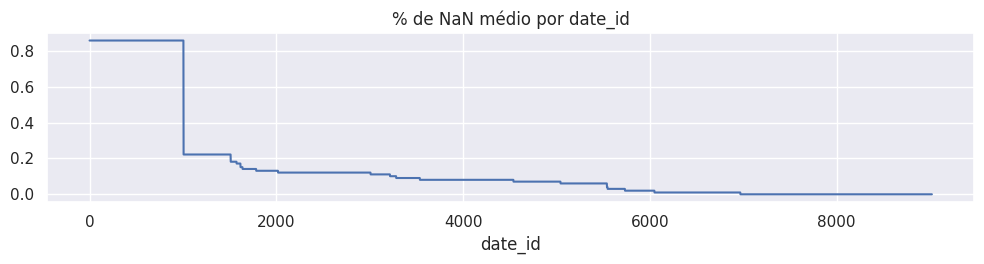

,family,n_cols,missing_pct,median_abs_corr
0,M,18,25.406151,0.138013
5,S,12,20.173299,0.082111
4,V,13,19.757318,0.146569
1,E,20,15.226139,0.136397
3,P,13,12.695164,0.099127
2,I,9,11.151757,0.180473
6,D,9,0.000000,0.023761


In [55]:
hm.set_data_columns(MARKET_COL, RF_COL, IS_SCORED_COL)

# Série do alvo e vol rolling
if "date_id" in train.columns:
    df_sorted = train.sort_values("date_id")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(df_sorted["date_id"], df_sorted[TARGET_COL], color="#4C72B0")
    axes[0].set_title("Alvo ao longo do tempo")
    axes[0].set_xlabel("date_id")
    axes[0].set_ylabel(TARGET_COL)
    roll20 = df_sorted[TARGET_COL].rolling(window=20, min_periods=10).std()
    roll60 = df_sorted[TARGET_COL].rolling(window=60, min_periods=20).std()
    axes[1].plot(df_sorted["date_id"], roll20, label="vol_20d", color="#55A868")
    axes[1].plot(df_sorted["date_id"], roll60, label="vol_60d", color="#C44E52")
    axes[1].set_title("Volatilidade rolling (20/60)")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Baseline: posição constante = 1 (buy & hold)
alloc_const = pd.Series(1.0, index=train.index)
sharpe_const, details_const = hm.adjusted_sharpe_score(
    train,
    alloc_const,
    market_col=MARKET_COL,
    rf_col=RF_COL,
    is_scored_col=IS_SCORED_COL,
)
print(f"Sharpe ajustado (alloc=1 constante): {sharpe_const:.4f} | vol estratégia={details_const.get('strategy_vol'):.4f}")

# Proporção de linhas scored (se existir)
if IS_SCORED_COL and IS_SCORED_COL in train.columns and "date_id" in train.columns:
    scored_by_date = train.groupby("date_id")[IS_SCORED_COL].mean()
    scored_by_date.plot(figsize=(10, 2.8), title="Proporção is_scored por date_id")
    plt.tight_layout()
    plt.show()

# Missing por data e por família
if "date_id" in train.columns:
    miss_by_date = train.groupby("date_id").apply(lambda df: df.isna().mean().mean())
    miss_by_date.plot(figsize=(10, 2.8), title="% de NaN médio por date_id")
    plt.tight_layout()
    plt.show()

families = ["M", "E", "I", "P", "V", "S", "D", "MOM"]
fam_rows = []
for fam in families:
    cols = [c for c in train.columns if c.startswith(fam)]
    if not cols:
        continue
    miss_pct = float(train[cols].isna().mean().mean() * 100)
    corr_mat = train[cols].corr().abs()
    if not corr_mat.empty:
        mask = ~np.eye(len(corr_mat), dtype=bool)
        median_corr = float(corr_mat.where(mask).stack().median())
    else:
        median_corr = np.nan
    fam_rows.append({"family": fam, "n_cols": len(cols), "missing_pct": miss_pct, "median_abs_corr": median_corr})

if fam_rows:
    fam_df = pd.DataFrame(fam_rows).sort_values("missing_pct", ascending=False)
    display(fam_df)

## 8. Validação temporal (Sharpe ajustado oficial)

## 8. Validação temporal (Sharpe ajustado oficial)
Métrica principal = Sharpe ajustado local. RMSE só é usado como diagnóstico secundário em cortes simples.

In [56]:
intentional_tuning_grid = [
    {"name": "base_clip", **INTENTIONAL_DEFAULTS},
    {"name": "soft_clip_z15", "clip_bounds": (-0.04, 0.04), "tanh_scale": 1.15, "zscore_window": 15, "zscore_clip": 4.0},
    {"name": "wide_clip_z25", "clip_bounds": (-0.06, 0.06), "tanh_scale": 0.9, "zscore_window": 25, "zscore_clip": 6.0},
]
intentional_cv_results = {}
intentional_summary_rows = []
for cfg in intentional_tuning_grid:
    cfg_name = cfg.get("name", f"cfg_{len(intentional_summary_rows)}")
    print(f"\nConfig intencional: {cfg_name} -> {cfg}")
    cfg_use = hm.default_config()
    cfg_use.intentional_cfg = {**INTENTIONAL_CFG, **cfg}
    metrics_cfg = pipeline.run_time_cv(train, feature_set="D_intentional", target_col=target_col, cfg=cfg_use, n_splits=4, val_frac=0.12)
    intentional_cv_results[cfg_name] = metrics_cfg
    summary_cfg = summarize_cv_metrics(metrics_cfg) or {}
    summary_cfg.update(
        {
            "config": cfg_name,
            "clip_bounds": cfg.get("clip_bounds"),
            "tanh_scale": cfg.get("tanh_scale"),
            "zscore_window": cfg.get("zscore_window"),
            "zscore_clip": cfg.get("zscore_clip"),
        }
    )
    intentional_summary_rows.append(summary_cfg)

intentional_summary_df = pd.DataFrame(intentional_summary_rows)
best_cfg = None
if not intentional_summary_df.empty and intentional_summary_df["sharpe_mean"].notna().any():
    best_idx = intentional_summary_df["sharpe_mean"].astype(float).idxmax()
    best_cfg = intentional_tuning_grid[int(best_idx)]
    INTENTIONAL_CFG = {**INTENTIONAL_CFG, **best_cfg}
    PIPELINE_CFG.intentional_cfg = INTENTIONAL_CFG
    PIPELINE_CFG.feature_cfg = PIPELINE_CFG.feature_cfg or FEATURE_CFG_DEFAULT
    print(f"\nMelhor config para features intencionais: {best_cfg.get('name')} | Sharpe={intentional_summary_df.loc[best_idx, 'sharpe_mean']:.4f}")
    print(f"INTENTIONAL_CFG atualizada: {INTENTIONAL_CFG}")
    display(intentional_summary_df[["config", "sharpe_mean", "sharpe_std", "k_median", "alpha_median", "clip_bounds", "tanh_scale", "zscore_window", "zscore_clip"]])
else:
    print("Calibração não retornou métricas; mantendo defaults.")

intentional_folds_rows = []
for cfg_name, metrics in intentional_cv_results.items():
    for m in metrics:
        intentional_folds_rows.append(
            {
                "config": cfg_name,
                "fold": m.get("fold"),
                "sharpe": m.get("sharpe"),
                "k": m.get("best_k"),
                "alpha": m.get("best_alpha"),
                "n_scored": m.get("n_scored"),
            }
        )
intentional_folds_df = pd.DataFrame(intentional_folds_rows)
if not intentional_folds_df.empty:
    display(intentional_folds_df.pivot(index="fold", columns="config", values="sharpe"))


Config intencional: base_clip -> {'name': 'base_clip', 'clip_bounds': (-0.05, 0.05), 'tanh_scale': 1.0, 'zscore_window': 20, 'zscore_clip': 5.0}

Config intencional: soft_clip_z15 -> {'name': 'soft_clip_z15', 'clip_bounds': (-0.04, 0.04), 'tanh_scale': 1.15, 'zscore_window': 15, 'zscore_clip': 4.0}

Config intencional: wide_clip_z25 -> {'name': 'wide_clip_z25', 'clip_bounds': (-0.06, 0.06), 'tanh_scale': 0.9, 'zscore_window': 25, 'zscore_clip': 6.0}

Melhor config para features intencionais: wide_clip_z25 | Sharpe=0.6473
INTENTIONAL_CFG atualizada: {'clip_bounds': (-0.06, 0.06), 'tanh_scale': 0.9, 'zscore_window': 25, 'zscore_clip': 6.0, 'name': 'wide_clip_z25'}


,config,sharpe_mean,sharpe_std,k_median,alpha_median,clip_bounds,tanh_scale,zscore_window,zscore_clip
0,base_clip,0.647331,0.309386,1.0,1.0,"(-0.05, 0.05)",1.00,20,5.0
1,soft_clip_z15,0.647328,0.309385,1.0,1.0,"(-0.04, 0.04)",1.15,15,4.0
2,wide_clip_z25,0.647332,0.309380,1.0,1.0,"(-0.06, 0.06)",0.90,25,6.0


config,base_clip,soft_clip_z15,wide_clip_z25
fold,,,
1,0.138560,0.138558,0.138571
2,0.826324,0.826315,0.826319
3,0.949360,0.949360,0.949360
4,0.675080,0.675080,0.675080


In [57]:
# Executa CV temporal usando pipeline unificado de features
train_fe_all, test_fe_all, feature_cols_main, feature_sets, main_feature_set = make_features(
    train,
    test_df=test,
    target_col=target_col,
    feature_set="D_intentional",
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
)
_df = train_fe_all

# Guardrail explícito: nenhum feature_set pode conter alvo ou retornos futuros (exceto versões lagged_).
_leak_terms = {str(target_col), "forward_returns", "risk_free_rate", "market_forward_excess_returns"}
_leak_terms = _leak_terms.union({t.lower() for t in _leak_terms})
for fs_name, cols in feature_sets.items():
    bad = []
    for col in cols:
        col_norm = str(col).lower()
        if any(term in col_norm for term in _leak_terms) and not col_norm.startswith("lagged_"):
            bad.append(col)
    assert not bad, f"Leakage detectado em {fs_name}: {bad}"

# Contagem de features por set
feat_counts = pd.DataFrame(
    [{"feature_set": name, "n_features": len(cols)} for name, cols in feature_sets.items()]
).sort_values("n_features", ascending=False)
print("Número de features por conjunto:")
display(feat_counts)

feature_cols_cv = feature_sets.get(main_feature_set, next(iter(feature_sets.values())))
print(f"Feature set principal para variações rápidas: {main_feature_set} ({len(feature_cols_cv)} cols)")
# Alias para compatibilidade com células seguintes
feature_cols = feature_cols_cv

cv_metrics = {}
stability_reports = {}
for name, cols in feature_sets.items():
    print(f"\n==== CV para {name} ({len(cols)} features) ====")
    cv_metrics[name] = pipeline.run_time_cv(train, feature_set=name, target_col=target_col, cfg=PIPELINE_CFG, n_splits=5, val_frac=0.10)
    sanity_shuffle_test(_df, cols, target_col, n_splits=3)
    stability_reports[name] = stability_check(_df, cols, target_col, configs=[(5, 0.1), (4, 0.15), (6, 0.10)])

Número de features por conjunto:


,feature_set,n_features
4,E_fe_oriented,139
3,D_intentional,139
5,F_v2_intentional,139
2,C_regimes,130
1,B_families,128
0,A_baseline,94


Feature set principal para variações rápidas: D_intentional (139 cols)

==== CV para A_baseline (94 features) ====

==== CV para B_families (128 features) ====

==== CV para C_regimes (130 features) ====

==== CV para D_intentional (139 features) ====

==== CV para E_fe_oriented (139 features) ====

==== CV para F_v2_intentional (139 features) ====


### Visualização rápida dos folds

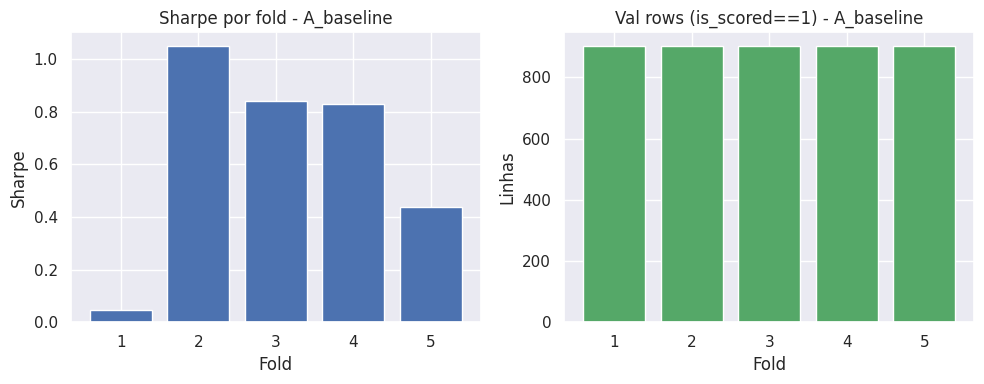

A_baseline: Sharpe médio=0.6408 | desvio=0.3572
A_baseline: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


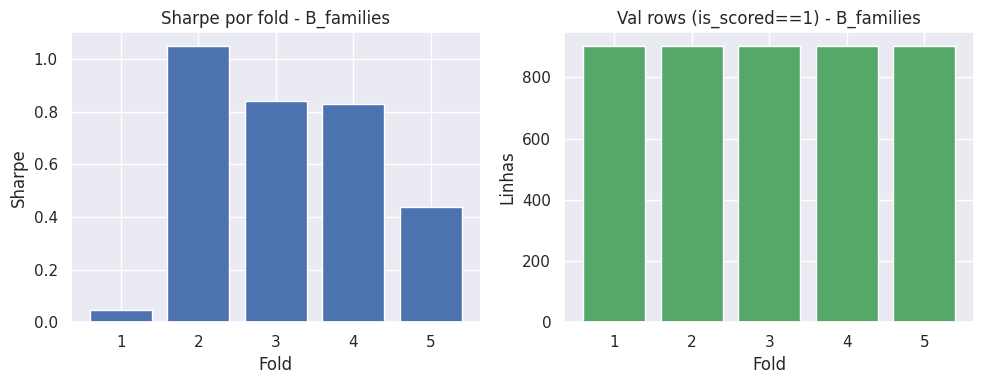

B_families: Sharpe médio=0.6408 | desvio=0.3572
B_families: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


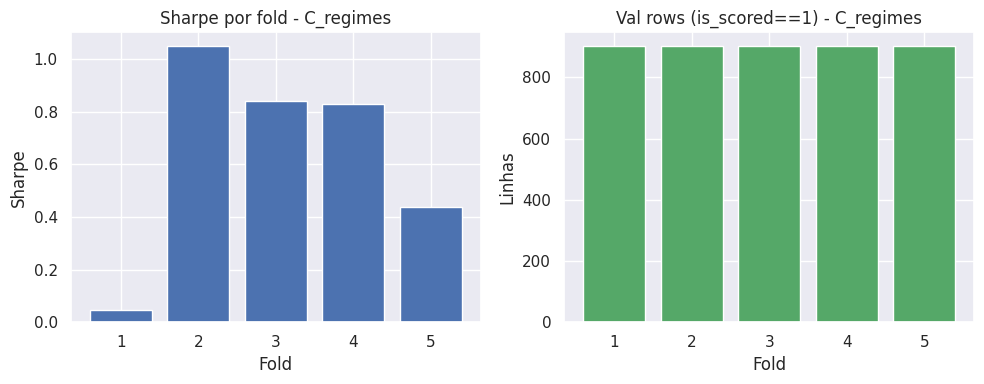

C_regimes: Sharpe médio=0.6408 | desvio=0.3572
C_regimes: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


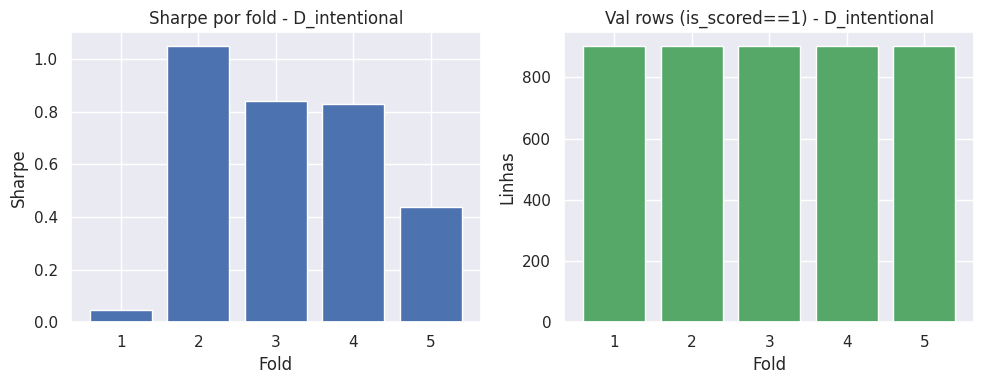

D_intentional: Sharpe médio=0.6408 | desvio=0.3572
D_intentional: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


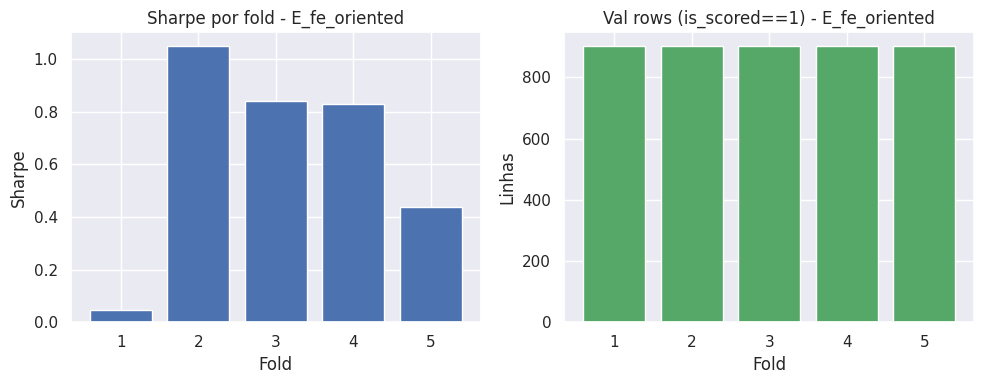

E_fe_oriented: Sharpe médio=0.6408 | desvio=0.3572
E_fe_oriented: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


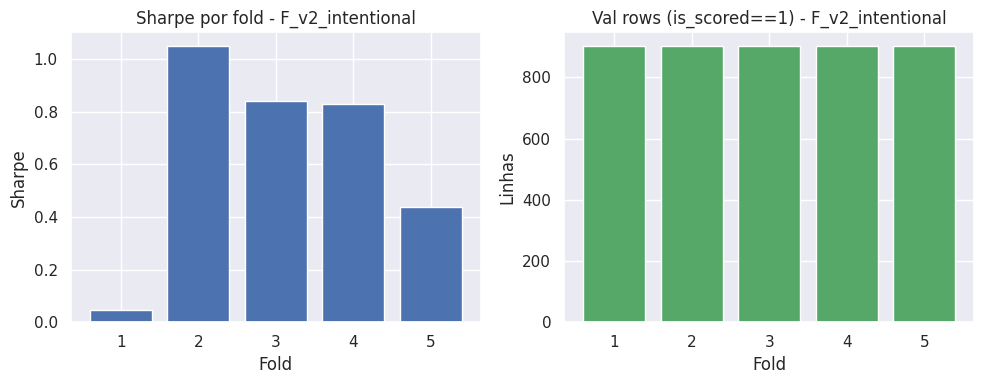

F_v2_intentional: Sharpe médio=0.6408 | desvio=0.3572
F_v2_intentional: n_scored fold (min/med/max) = 902/902/902
Para robustez, teste n_splits=3 e n_splits=6 e compare.


In [58]:
import matplotlib.pyplot as plt

for name, metrics in cv_metrics.items():
    if not metrics:
        continue
    df_cv = pd.DataFrame(metrics)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(df_cv["fold"], df_cv["sharpe"], color="#4C72B0")
    axes[0].set_title(f"Sharpe por fold - {name}")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Sharpe")
    axes[1].bar(df_cv["fold"], df_cv["n_scored"], color="#55A868")
    axes[1].set_title(f"Val rows (is_scored==1) - {name}")
    axes[1].set_xlabel("Fold")
    axes[1].set_ylabel("Linhas")
    plt.tight_layout()
    plt.show()

    sharpe_vals = [m["sharpe"] for m in metrics]
    n_scored_vals = df_cv["n_scored"]
    print(f"{name}: Sharpe médio={np.mean(sharpe_vals):.4f} | desvio={np.std(sharpe_vals):.4f}")
    print(f"{name}: n_scored fold (min/med/max) = {int(n_scored_vals.min())}/{int(n_scored_vals.median())}/{int(n_scored_vals.max())}")
    print("Para robustez, teste n_splits=3 e n_splits=6 e compare.")

### CV com engenharia recalculada por fold (fit_ref)
Recalcula winsor/clipping/z-score e intenções usando apenas o treino de cada fold (reduz risco de olhar distribuição futura).

In [59]:
print("\n=== CV (fit_ref por fold) usando D_intentional ===")
metrics_fitref = pipeline.run_time_cv_fitref(
    train, feature_set="D_intentional", target_col=target_col, cfg=PIPELINE_CFG, n_splits=4, val_frac=0.12, num_boost_round=180
)
if metrics_fitref:
    df_fitref = pd.DataFrame(metrics_fitref)
    display(df_fitref)
    print(f"Sharpe médio (fit_ref): {df_fitref['sharpe'].mean():.4f} | std={df_fitref['sharpe'].std():.4f}")
else:
    print("CV fit_ref não retornou métricas (cheque date_id / is_scored).")


=== CV (fit_ref por fold) usando D_intentional ===


,fold,sharpe,best_k,best_alpha,n_scored,strategy_vol,alloc_mode
0,1,0.138558,1.0,1.0,1082,23.419503,fixed
1,2,0.826317,1.0,1.0,1082,13.207487,fixed
2,3,0.949196,1.0,1.0,1082,16.101471,fixed
3,4,0.675073,1.0,1.0,1082,16.246462,fixed


Sharpe médio (fit_ref): 0.6473 | std=0.3572


### LGBM variantes (peso is_scored e modelo conservador)
- Peso para is_scored: treina dando menor peso para linhas não pontuadas.
- Modelo conservador: configuração com mais regularização para compor ensemble.

In [60]:
print("\n=== CV LGBM ponderado por is_scored (peso_non_scored=0.2) ===")
metrics_weighted = pipeline.run_time_cv(
    train,
    feature_set=PIPELINE_FEATURE_SET,
    target_col=target_col,
    cfg=PIPELINE_CFG,
    n_splits=4,
    val_frac=0.12,
    num_boost_round=180,
    weight_scored=1.0,
    weight_unscored=0.2,
    log_prefix="[weighted]",
)
if metrics_weighted:
    print(f"Sharpe médio (weighted): {np.mean([m['sharpe'] for m in metrics_weighted]):.4f}")

params_conservative = {
    "num_leaves": 31,
    "learning_rate": 0.03,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
}
print("\n=== CV LGBM conservador (mais regularização) ===")
metrics_cons = pipeline.run_time_cv(
    train,
    feature_set=PIPELINE_FEATURE_SET,
    target_col=target_col,
    cfg=PIPELINE_CFG,
    n_splits=4,
    val_frac=0.12,
    params_override=params_conservative,
    num_boost_round=180,
    early_stopping_rounds=15,
    log_prefix="[cons]",
)
if metrics_cons:
    print(f"Sharpe médio (conservador): {np.mean([m['sharpe'] for m in metrics_cons]):.4f}")


=== CV LGBM ponderado por is_scored (peso_non_scored=0.2) ===
Sharpe médio (weighted): 0.6473

=== CV LGBM conservador (mais regularização) ===
Sharpe médio (conservador): 0.6474


### Resumo padronizado de CV (Sharpe ajustado + n_scored)

In [61]:
cv_summary_rows = []
for name, metrics in cv_metrics.items():
    summary = summarize_cv_metrics(metrics)
    if summary:
        summary.update({"feature_set": name, "config": "n_splits=5 | val_frac=0.10", "n_features": len(feature_sets.get(name, []))})
        cv_summary_rows.append(summary)
for name, reports in stability_reports.items():
    for rep in reports:
        row = dict(rep)
        row.update({"feature_set": name, "config": f"n_splits={rep['n_splits']} | val_frac={rep['val_frac']:.2f}", "n_features": len(feature_sets.get(name, []))})
        cv_summary_rows.append(row)
cv_summary_df = pd.DataFrame(cv_summary_rows)
if not cv_summary_df.empty:
    cols_order = [
        "feature_set",
        "config",
        "n_features",
        "sharpe_mean",
        "sharpe_std",
        "k_median",
        "alpha_median",
        "n_scored_min",
        "n_scored_med",
        "n_scored_max",
        "const_sharpe_mean",
        "folds",
    ]
    display(cv_summary_df[cols_order])

# Diagnóstico: delta vs baseline (alloc constante) por feature set/fold
def _delta_vs_baseline(metrics_dict: dict) -> pd.DataFrame:
    rows = []
    for name, metrics in metrics_dict.items():
        if not metrics:
            continue
        df_m = pd.DataFrame(metrics)
        if "const_sharpe" not in df_m.columns:
            continue
        delta = df_m["sharpe"] - df_m["const_sharpe"]
        rows.append(
            {
                "feature_set": name,
                "mean_delta": float(delta.mean()),
                "p20_delta": float(delta.quantile(0.2)),
                "median_delta": float(delta.median()),
                "min_delta": float(delta.min()),
                "max_delta": float(delta.max()),
                "sharpe_mean": float(df_m["sharpe"].mean()),
                "const_mean": float(df_m["const_sharpe"].mean()),
                "folds": len(df_m),
            }
        )
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows).sort_values(["mean_delta", "p20_delta"], ascending=False)

delta_baseline_df = _delta_vs_baseline(cv_metrics)
if not delta_baseline_df.empty:
    print("Sharpe delta vs baseline (alloc=1.0) — positivo = modelo agrega sobre o constante:")
    display(delta_baseline_df)
else:
    print("Sem métricas para delta vs baseline (const_sharpe ausente).")

# Baseline de risco sem predição: usa apenas regime/std para modular exposição.
def risk_managed_baseline_cv(
    df: pd.DataFrame,
    *,
    k: float = 1.0,
    alpha: float = 1.0,
    allocation_cfg: AllocationConfig | None = None,
    n_splits: int = 5,
    val_frac: float = 0.10,
    gap: int = 0,
    cfg=PIPELINE_CFG,
):
    cfg_use = cfg or PIPELINE_CFG
    market_col = cfg_use.market_col or MARKET_COL
    rf_col = cfg_use.rf_col or RF_COL
    is_scored_col = cfg_use.is_scored_col or IS_SCORED_COL
    alloc_cfg = allocation_cfg or AllocationConfig()
    splits = make_time_splits(df, date_col="date_id", n_splits=n_splits, val_frac=val_frac, gap=gap)
    rows = []
    for i, (_mask_tr, mask_val) in enumerate(splits, 1):
        df_val = df.loc[mask_val].copy()
        if df_val.empty:
            continue
        const_signal = pd.Series(1.0, index=df_val.index)
        alloc = apply_allocation_strategy(const_signal, df_val, k=float(k), alpha=float(alpha), cfg=alloc_cfg)
        sharpe_adj, details = adjusted_sharpe_score(
            df_val,
            alloc,
            market_col=market_col,
            rf_col=rf_col,
            is_scored_col=is_scored_col,
        )
        n_scored = int(df_val[is_scored_col].sum()) if is_scored_col and is_scored_col in df_val.columns else len(df_val)
        rows.append(
            {
                "fold": i,
                "sharpe": sharpe_adj,
                "strategy_vol": details.get("strategy_vol"),
                "n_val": len(df_val),
                "n_scored": n_scored,
            }
        )
    return rows

risk_baseline_cfg = ALLOC_STRATEGY_CFG if "ALLOC_STRATEGY_CFG" in locals() else AllocationConfig()
metrics_risk_baseline = risk_managed_baseline_cv(
    train,
    k=PIPELINE_CFG.alloc_k if hasattr(PIPELINE_CFG, "alloc_k") else 1.0,
    alpha=PIPELINE_CFG.alloc_alpha if hasattr(PIPELINE_CFG, "alloc_alpha") else 1.0,
    allocation_cfg=risk_baseline_cfg,
    n_splits=5,
    val_frac=0.10,
)
if metrics_risk_baseline:
    df_risk_base = pd.DataFrame(metrics_risk_baseline)
    print(
        f"Baseline de risco (sem pred): Sharpe médio={df_risk_base['sharpe'].mean():.4f} | "
        f"P20={df_risk_base['sharpe'].quantile(0.2):.4f} | vol_mediana={df_risk_base['strategy_vol'].median():.4f}"
    )
    display(df_risk_base)
else:
    print("Baseline de risco (sem pred) não pôde ser calculado (cheque date_id/is_scored).")

,feature_set,config,n_features,sharpe_mean,sharpe_std,k_median,alpha_median,n_scored_min,n_scored_med,n_scored_max,const_sharpe_mean,folds
0,A_baseline,n_splits=5 | val_frac=0.10,94,0.640814,0.357168,1.0,1.0,902,902,902,0.640803,5
1,B_families,n_splits=5 | val_frac=0.10,128,0.640809,0.357172,1.0,1.0,902,902,902,0.640803,5
2,C_regimes,n_splits=5 | val_frac=0.10,130,0.640812,0.357171,1.0,1.0,902,902,902,0.640803,5
3,D_intentional,n_splits=5 | val_frac=0.10,139,0.640809,0.357173,1.0,1.0,902,902,902,0.640803,5
4,E_fe_oriented,n_splits=5 | val_frac=0.10,139,0.640809,0.357173,1.0,1.0,902,902,902,0.640803,5
5,F_v2_intentional,n_splits=5 | val_frac=0.10,139,0.640809,0.357173,1.0,1.0,902,902,902,0.640803,5
6,A_baseline,n_splits=5 | val_frac=0.10,94,0.640815,0.357167,1.0,1.0,902,902,902,0.640803,5
7,A_baseline,n_splits=4 | val_frac=0.15,94,0.617775,0.325382,1.0,1.0,1353,1353,1353,0.617755,3
8,A_baseline,n_splits=6 | val_frac=0.10,94,0.640815,0.357167,1.0,1.0,902,902,902,0.640803,5
9,B_families,n_splits=5 | val_frac=0.10,128,0.640809,0.357172,1.0,1.0,902,902,902,0.640803,5


Sharpe delta vs baseline (alloc=1.0) — positivo = modelo agrega sobre o constante:


,feature_set,mean_delta,p20_delta,median_delta,min_delta,max_delta,sharpe_mean,const_mean,folds
0,A_baseline,0.000011,2.595143e-06,0.000005,-3.643077e-07,0.000028,0.640814,0.640803,5
2,C_regimes,0.000009,1.994137e-06,0.000005,-2.357431e-06,0.000021,0.640812,0.640803,5
3,D_intentional,0.000006,1.966235e-06,0.000005,1.067109e-08,0.000014,0.640809,0.640803,5
4,E_fe_oriented,0.000006,1.966235e-06,0.000005,1.067109e-08,0.000014,0.640809,0.640803,5
5,F_v2_intentional,0.000006,1.966235e-06,0.000005,1.067109e-08,0.000014,0.640809,0.640803,5
1,B_families,0.000006,4.931457e-07,0.000005,2.305113e-07,0.000014,0.640809,0.640803,5


Baseline de risco (sem pred): Sharpe médio=0.3090 | P20=0.1508 | vol_mediana=33.7146


,fold,sharpe,strategy_vol,n_val,n_scored
0,1,-0.033481,46.538976,902,902
1,2,0.540165,30.372157,902,902
2,3,0.431895,25.342516,902,902
3,4,0.409737,36.676470,902,902
4,5,0.196867,33.714620,902,902


In [62]:
# Walk-forward curto (janelas de validação de 30–120 dias) para aproximar horizonte de 10 dias do test
if "date_id" in train.columns:
    n_dates = train["date_id"].nunique()
    short_windows = [30, 60, 90, 120]
    wf_rows = []
    for win in short_windows:
        val_frac = max(1 / n_dates, min(0.5, win / n_dates))
        metrics_short = pipeline.run_time_cv(
            train,
            feature_set=PIPELINE_FEATURE_SET,
            target_col=target_col,
            cfg=PIPELINE_CFG,
            n_splits=5,
            val_frac=val_frac,
            gap=5,
            num_boost_round=180,
        )
        summary_short = summarize_cv_metrics(metrics_short) or {}
        sharpe_vals = [m["sharpe"] for m in metrics_short] if metrics_short else []
        wf_rows.append(
            {
                "window_days": win,
                "val_frac": val_frac,
                "folds": len(metrics_short),
                "sharpe_mean": summary_short.get("sharpe_mean"),
                "sharpe_p20": float(pd.Series(sharpe_vals).quantile(0.2)) if sharpe_vals else np.nan,
                "const_sharpe_mean": summary_short.get("const_sharpe_mean"),
            }
        )
    wf_df = pd.DataFrame(wf_rows)
    print("Walk-forward curto (val windows 30–120 dias):")
    display(wf_df)
else:
    print("Sem date_id; walk-forward curto não aplicável.")

Walk-forward curto (val windows 30–120 dias):


,window_days,val_frac,folds,sharpe_mean,sharpe_p20,const_sharpe_mean
0,30,0.003326,5,-1.389516,-2.745930,-1.389592
1,60,0.006651,5,-1.117049,-1.786764,-1.117193
2,90,0.009977,5,-0.252051,-1.263636,-0.252137
3,120,0.013302,5,0.183706,-0.964468,0.183643


In [63]:
# Baseline direcional simples (lags/regime) para diversificar sinais sem modelo
def build_directional_signal(df: pd.DataFrame) -> pd.Series:
    if "lagged_market_forward_excess_returns" in df.columns:
        lag = pd.to_numeric(df["lagged_market_forward_excess_returns"], errors="coerce")
    elif MARKET_COL in df.columns:
        lag = pd.to_numeric(df[MARKET_COL], errors="coerce").shift(1)
    else:
        return pd.Series(0.0, index=df.index)
    lag = lag.clip(-0.03, 0.03)
    regime = df.get("regime_high_vol")
    if regime is not None:
        lag = lag * np.where(regime.fillna(0) > 0, 0.5, 1.0)
    return lag.fillna(0.0)


def directional_rule_cv(
    df: pd.DataFrame,
    *,
    allocation_cfg: AllocationConfig | None = None,
    n_splits: int = 5,
    val_frac: float = 0.10,
    gap: int = 5,
    cfg=PIPELINE_CFG,
):
    cfg_use = cfg or PIPELINE_CFG
    market_col = cfg_use.market_col or MARKET_COL
    rf_col = cfg_use.rf_col or RF_COL
    is_scored_col = cfg_use.is_scored_col or IS_SCORED_COL
    sig_full = build_directional_signal(df)
    alloc_cfg = allocation_cfg or AllocationConfig()
    splits = make_time_splits(df, date_col="date_id", n_splits=n_splits, val_frac=val_frac, gap=gap)
    rows = []
    for i, (_mask_tr, mask_val) in enumerate(splits, 1):
        df_val = df.loc[mask_val].copy()
        if df_val.empty:
            continue
        sig_val = sig_full.loc[mask_val]
        alloc = apply_allocation_strategy(sig_val, df_val, k=float(cfg_use.alloc_k), alpha=float(cfg_use.alloc_alpha), cfg=alloc_cfg)
        sharpe_adj, details = adjusted_sharpe_score(
            df_val,
            alloc,
            market_col=market_col,
            rf_col=rf_col,
            is_scored_col=is_scored_col,
        )
        n_scored = int(df_val[is_scored_col].sum()) if is_scored_col and is_scored_col in df_val.columns else len(df_val)
        rows.append(
            {
                "fold": i,
                "sharpe": sharpe_adj,
                "strategy_vol": details.get("strategy_vol"),
                "n_val": len(df_val),
                "n_scored": n_scored,
            }
        )
    return rows


directional_metrics = directional_rule_cv(
    train,
    allocation_cfg=ALLOC_STRATEGY_CFG if "ALLOC_STRATEGY_CFG" in locals() else AllocationConfig(),
    n_splits=5,
    val_frac=0.10,
    gap=5,
)
if directional_metrics:
    df_dir = pd.DataFrame(directional_metrics)
    print(
        f"Baseline direcional (lag/regime, sem modelo): Sharpe médio={df_dir['sharpe'].mean():.4f} | "
        f"P20={df_dir['sharpe'].quantile(0.2):.4f} | vol_mediana={df_dir['strategy_vol'].median():.4f}"
    )
    display(df_dir)
else:
    print("Baseline direcional não pôde ser calculado (cheque date_id/is_scored).")

Baseline direcional (lag/regime, sem modelo): Sharpe médio=0.6990 | P20=0.5193 | vol_mediana=16.7600


,fold,sharpe,strategy_vol,n_val,n_scored
0,1,0.024299,23.113464,902,902
1,2,1.007513,15.178798,902,902
2,3,0.914830,12.609497,902,902
3,4,0.849258,18.341123,902,902


### Comparação: feature sets D_intentional vs C_regimes (Sharpe local)

In [64]:
compare_sets = ["C_regimes", "D_intentional"]
comp_rows = []
for name in compare_sets:
    summary = summarize_cv_metrics(cv_metrics.get(name, []))
    if summary:
        summary.update({"feature_set": name, "config": "n_splits=5 | val_frac=0.10"})
        comp_rows.append(summary)
if comp_rows:
    comp_df = pd.DataFrame(comp_rows)
    cols_base = ["feature_set", "config", "sharpe_mean", "sharpe_std", "k_median", "alpha_median", "n_scored_med", "n_scored_min", "n_scored_max"]
    display(comp_df[cols_base])
    if set(compare_sets).issubset(set(comp_df["feature_set"])):
        sharpe_gain = (
            comp_df.loc[comp_df["feature_set"] == "D_intentional", "sharpe_mean"].values[0]
            - comp_df.loc[comp_df["feature_set"] == "C_regimes", "sharpe_mean"].values[0]
        )
        print(f"Ganho de Sharpe (D_intentional - C_regimes): {sharpe_gain:+.4f}")
else:
    print("CV ausente para algum dos conjuntos (C_regimes ou D_intentional). Rode as células de CV primeiro.")

,feature_set,config,sharpe_mean,sharpe_std,k_median,alpha_median,n_scored_med,n_scored_min,n_scored_max
0,C_regimes,n_splits=5 | val_frac=0.10,0.640812,0.357171,1.0,1.0,902,902,902
1,D_intentional,n_splits=5 | val_frac=0.10,0.640809,0.357173,1.0,1.0,902,902,902


Ganho de Sharpe (D_intentional - C_regimes): -0.0000


### Pseudo-leaderboard / holdout temporal (expanding window)
- Checa desempenho em um bloco final do histórico (10–15%) como proxy de LB pública.
- Compara treino completo vs. treino filtrado em `is_scored==1` nas avaliações.

In [65]:
# `expanding_holdout_eval` é fornecida pelo pacote `hull_tactical.models`.

### Treino scored vs. ponderado (is_scored) – comparação clara (full vs. scored_only vs. weighted)

In [66]:
is_scored_configs = [
    {"name": "full", "train_only_scored": False, "weight_unscored": 1.0},
    {"name": "weighted_0.2", "train_only_scored": False, "weight_unscored": 0.2},
    {"name": "scored_only", "train_only_scored": True, "weight_unscored": None},
]

is_scored_results = []
for cfg in is_scored_configs:
    print(f"\n=== CV is_scored cfg={cfg['name']} ===")
    metrics_cfg = pipeline.run_time_cv(
        train,
        feature_set=PIPELINE_FEATURE_SET,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=4,
        val_frac=0.12,
        weight_scored=1.0,
        weight_unscored=cfg["weight_unscored"],
        train_only_scored=cfg["train_only_scored"],
        log_prefix=f"[{cfg['name']}]",
    )
    summary = summarize_cv_metrics(metrics_cfg) or {}
    holdouts = pipeline.run_holdout_eval(
        train,
        feature_set=PIPELINE_FEATURE_SET,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12, 0.15),
        train_only_scored=cfg["train_only_scored"],
        use_weights=cfg["weight_unscored"] is not None and cfg["weight_unscored"] != 1.0,
        weight_unscored=cfg["weight_unscored"],
        label_prefix=f"ho_{cfg['name']}",
    )
    hold12 = next((h for h in holdouts if h and abs(h.get("holdout_frac", 0) - 0.12) < 1e-9), None)
    hold15 = next((h for h in holdouts if h and abs(h.get("holdout_frac", 0) - 0.15) < 1e-9), None)
    is_scored_results.append(
        {
            "config": cfg["name"],
            "cv_sharpe_mean": summary.get("sharpe_mean"),
            "cv_sharpe_std": summary.get("sharpe_std"),
            "cv_k_med": summary.get("k_median"),
            "cv_alpha_med": summary.get("alpha_median"),
            "holdout12_sharpe": hold12["sharpe_holdout"] if hold12 else np.nan,
            "holdout15_sharpe": hold15["sharpe_holdout"] if hold15 else np.nan,
        }
    )

is_scored_df = pd.DataFrame(is_scored_results)
if not is_scored_df.empty:
    display(is_scored_df.sort_values("holdout12_sharpe", ascending=False))


is_scored_cfg_lookup = {c["name"]: c for c in is_scored_configs}
chosen_scored_cfg = choose_scored_strategy(is_scored_df, is_scored_cfg_lookup)
print(
    f"Estratégia escolhida para treino final: {chosen_scored_cfg['name']} | train_only_scored={chosen_scored_cfg['train_only_scored']} | "
    f"weight_unscored={chosen_scored_cfg.get('weight_unscored')} | {chosen_scored_cfg['note']}"
)


=== CV is_scored cfg=full ===

=== CV is_scored cfg=weighted_0.2 ===

=== CV is_scored cfg=scored_only ===


,config,cv_sharpe_mean,cv_sharpe_std,cv_k_med,cv_alpha_med,holdout12_sharpe,holdout15_sharpe
0,full,0.647332,0.30938,1.0,1.0,0.442292,0.742068
1,weighted_0.2,0.647332,0.30938,1.0,1.0,0.442292,0.742068
2,scored_only,0.647332,0.30938,1.0,1.0,0.442292,0.742068


Estratégia escolhida para treino final: full | train_only_scored=False | weight_unscored=1.0 | holdout≈0.5922, cv≈0.6473, cfg=full


## 9. Baselines simples (constante e linear)

In [67]:
# Baselines rápidos usando o feature set A (baseline)
evaluate_baselines(_df, feature_sets["A_baseline"], target_col)
# Cutoff alternativo para estabilidade (0.85)
_tr_alt, _va_alt = time_split(_df, cutoff=0.85)
print(f"Split alternativo 85/15: train={len(_tr_alt)}, val={len(_va_alt)}")

Split alternativo 85/15: train=7667, val=1354


## 10. Split temporal simples e baseline LightGBM

In [68]:
# Usa o melhor conjunto (A ou B) com base no Sharpe médio da CV anterior
best_set = "A_baseline"
best_mean = -np.inf
for name, metrics in cv_metrics.items():
    if metrics:
        mean_sharpe = np.mean([m["sharpe"] for m in metrics])
        if mean_sharpe > best_mean:
            best_mean = mean_sharpe
            best_set = name
feature_cols_best = feature_sets.get(best_set, feature_sets["A_baseline"])
print(f"Baseline 80/20 usando feature set: {best_set} ({len(feature_cols_best)} cols)")

train_df, val_df = time_split(_df, cutoff=0.8)
train_aligned, val_aligned, cols_use = align_feature_frames(train_df, val_df, feature_cols_best)
train_df_proc, keep_cols, medians = preprocess_basic(train_aligned, cols_use)
val_df_proc, _, _ = preprocess_basic(val_aligned, cols_use, ref_cols=keep_cols, ref_medians=medians)

X_train = train_df_proc.drop(columns=[target_col], errors="ignore")
X_val = val_df_proc.drop(columns=[target_col], errors="ignore")
y_train = train_df[target_col]
y_val = val_df[target_col]

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
params = {"objective": "regression", "metric": "rmse", **BEST_PARAMS}
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)],
)
best_iter = model.best_iteration or model.current_iteration()
pred_val = model.predict(X_val, num_iteration=best_iter)
best_k_val, best_alpha_val, _ = optimize_allocation_scale(
    pred_val, val_df, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
)
alloc_val = map_return_to_alloc(pred_val, k=best_k_val, intercept=best_alpha_val)
rmse = mean_squared_error(y_val, pred_val) ** 0.5
sharpe_adj, details_val = adjusted_sharpe_score(
    val_df, pd.Series(alloc_val, index=val_df.index), market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
)
n_scored_val = int(val_df[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in val_df.columns else len(val_df)
print(
    f"Sharpe ajustado (split 80/20): {sharpe_adj:.4f} | alpha={best_alpha_val:.2f} | k={best_k_val:.2f} | vol={details_val.get('strategy_vol', float('nan')):.2f} | RMSE={rmse:.6f} | best_iter={best_iter} | n_scored={n_scored_val}/{len(val_df)}"
)
if pd.notna(sharpe_adj) and sharpe_adj != -np.inf:
    # Mantemos RMSE como diagnóstico secundário; Sharpe ajustado é a métrica principal.
    ...

Baseline 80/20 usando feature set: A_baseline (94 cols)
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	train's rmse: 0.0104101	valid's rmse: 0.0111155
Sharpe ajustado (split 80/20): 0.6493 | alpha=1.00 | k=3.00 | vol=17.61 | RMSE=0.011115 | best_iter=15 | n_scored=1805/1805


## 11. Ensembles (Sharpe ponderado + bagging de seeds)

In [69]:
pred_frames = {}
ensemble_sources = {}

# Baseline constante (alocação 1.0) na CV temporal para referência
metrics_const = constant_allocation_cv(_df, n_splits=5, val_frac=0.1)

# LGBM com bagging de seeds
bagging_seeds = [SEED, 101, 2024]
lgb_preds_by_seed = []
metrics_lgb_by_seed = {}
for seed_val in bagging_seeds:
    metrics_seed, preds_seed = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="lgb", n_splits=5, seed=seed_val)
    metrics_lgb_by_seed[seed_val] = metrics_seed
    if not preds_seed.empty:
        preds_seed["seed"] = seed_val
        lgb_preds_by_seed.append(preds_seed)
    sharpe_seed = np.mean([m["sharpe"] for m in metrics_seed]) if metrics_seed else np.nan
    print(f"LGB seed {seed_val}: Sharpe CV médio={sharpe_seed:.4f}" if metrics_seed else f"LGB seed {seed_val}: sem métricas.")

metrics_lgb = metrics_lgb_by_seed.get(SEED, [])
preds_lgb = next((df for df in lgb_preds_by_seed if not df.empty and df["seed"].iloc[0] == SEED), pd.DataFrame())

metrics_lgb_bag = []
preds_lgb_bag = pd.DataFrame()
if lgb_preds_by_seed:
    alloc_mat = pd.concat([df["alloc"] for df in lgb_preds_by_seed], axis=1)
    alloc_mat.columns = [f"alloc_seed_{df['seed'].iloc[0]}" for df in lgb_preds_by_seed]
    alloc_mat["alloc"] = alloc_mat.mean(axis=1)
    pred_mat = pd.concat([df["pred_return"] for df in lgb_preds_by_seed], axis=1)
    pred_mean = pred_mat.mean(axis=1)
    fold_map = lgb_preds_by_seed[0][["fold", "is_scored"]]
    preds_lgb_bag = pd.DataFrame(
        {
            "alloc": alloc_mat["alloc"],
            "pred_return": pred_mean,
            "target": _df.loc[alloc_mat.index, target_col],
            "forward_returns": _df.loc[alloc_mat.index, MARKET_COL],
            "risk_free_rate": _df.loc[alloc_mat.index, RF_COL],
            "is_scored": fold_map["is_scored"],
            "fold": fold_map["fold"],
            "seed": -1,
        }
    )
    for fold_id, fold_df in preds_lgb_bag.groupby("fold"):
        sharpe, details = adjusted_sharpe_score(
            _df.loc[fold_df.index],
            fold_df["alloc"],
            market_col=MARKET_COL,
            rf_col=RF_COL,
            is_scored_col=IS_SCORED_COL,
        )
        metrics_lgb_bag.append(
            {
                "fold": int(fold_id),
                "sharpe": sharpe,
                "best_k": np.nan,
                "best_alpha": np.nan,
                "n_val": len(fold_df),
                "n_scored": int(fold_df["is_scored"].sum()),
                "strategy_vol": details.get("strategy_vol"),
                "seed": -1,
            }
        )
    mean_bag = np.mean([m["sharpe"] for m in metrics_lgb_bag]) if metrics_lgb_bag else np.nan
    print(f"LGB bagging ({len(bagging_seeds)} seeds): Sharpe CV médio={mean_bag:.4f}")

# LGBM ponderado por is_scored
metrics_lgb_weighted, preds_lgb_weighted = [], pd.DataFrame()
weight_unscored_cv = 0.2
metrics_lgb_weighted, preds_lgb_weighted = run_cv_preds(
    _df,
    feature_cols_cv,
    target_col,
    model_kind="lgb",
    n_splits=5,
    val_frac=0.10,
    weight_scored=1.0,
    weight_unscored=weight_unscored_cv,
)
print(
    f"LGB weighted CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_weighted]):.4f}"
    if metrics_lgb_weighted
    else "LGB weighted CV sem métricas."
)

# LGBM treinado apenas com linhas is_scored==1
metrics_lgb_scored, preds_lgb_scored = run_cv_preds(
    _df,
    feature_cols_cv,
    target_col,
    model_kind="lgb",
    n_splits=5,
    val_frac=0.10,
    train_only_scored=True,
)
print(
    f"LGB scored-only CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_scored]):.4f}"
    if metrics_lgb_scored
    else "LGB scored-only CV sem métricas."
)

# LGBM conservador (mais regularização)
params_conservative_use = params_conservative if "params_conservative" in globals() else {
    "num_leaves": 31,
    "learning_rate": 0.03,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
}
metrics_lgb_cons, preds_lgb_cons = run_cv_preds(
    _df, feature_cols, target_col, model_kind="lgb", params=params_conservative_use, n_splits=5, val_frac=0.10
)
print(
    f"LGB conservador CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_lgb_cons]):.4f}"
    if metrics_lgb_cons
    else "LGB conservador CV sem métricas."
)

# Ridge com feature set A (mais simples)
metrics_ridge, preds_ridge = run_cv_preds(_df, feature_sets["A_baseline"], target_col, model_kind="ridge", n_splits=5)
print(f"Ridge CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_ridge]):.4f}" if metrics_ridge else "Ridge CV sem métricas.")

# XGBoost opcional (só roda se xgboost estiver instalado)
metrics_xgb, preds_xgb = [], pd.DataFrame()
if HAS_XGB:
    metrics_xgb, preds_xgb = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="xgb", n_splits=5)
    print(f"XGB CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_xgb]):.4f}" if metrics_xgb else "XGB CV sem métricas.")
else:
    print("XGBoost não disponível; pulei.")

# CatBoost opcional
metrics_cat, preds_cat = [], pd.DataFrame()
if HAS_CAT:
    metrics_cat, preds_cat = run_cv_preds(_df, feature_cols_cv, target_col, model_kind="cat", n_splits=5)
    print(f"CatBoost CV Sharpe médio: {np.mean([m['sharpe'] for m in metrics_cat]):.4f}" if metrics_cat else "CatBoost CV sem métricas.")
else:
    print("CatBoost não disponível; pulei.")

# Delta vs baseline (alloc=1.0) por fold e percentis — evita ler só médias
def delta_vs_const(metrics_model, metrics_const, name="model"):
    if not metrics_model or not metrics_const:
        print(f"[{name}] métricas insuficientes para delta vs const.")
        return None, None
    df_m = pd.DataFrame(metrics_model).copy()
    df_c = pd.DataFrame(metrics_const).copy()
    df = df_m.merge(df_c[["fold", "sharpe"]].rename(columns={"sharpe": "sharpe_const"}), on="fold", how="left")
    df["delta"] = df["sharpe"] - df["sharpe_const"]
    summ = df["delta"].describe(percentiles=[0.2, 0.5, 0.8])[["mean", "std", "20%", "50%", "80%", "min", "max"]]
    print(f"\nDelta vs const ({name})")
    display(df[["fold", "sharpe", "sharpe_const", "delta", "best_k", "best_alpha"]])
    display(summ.to_frame(name="delta"))
    return df, summ


# Rode deltas para os principais modelos (ajuste conforme métricas disponíveis)
_ = delta_vs_const(metrics_lgb_bag, metrics_const, "lgb_bag")
_ = delta_vs_const(metrics_lgb_weighted, metrics_const, "lgb_weighted")
_ = delta_vs_const(metrics_lgb_cons, metrics_const, "lgb_conservative")
_ = delta_vs_const(metrics_lgb_scored, metrics_const, "lgb_scored_only")
_ = delta_vs_const(metrics_ridge, metrics_const, "ridge")
if HAS_XGB:
    _ = delta_vs_const(metrics_xgb, metrics_const, "xgb")
if HAS_CAT:
    _ = delta_vs_const(metrics_cat, metrics_const, "cat")

if not preds_lgb_bag.empty:
    ensemble_sources["lgb_bag"] = {"preds": preds_lgb_bag, "metrics": metrics_lgb_bag}
elif not preds_lgb.empty:
    ensemble_sources["lgb"] = {"preds": preds_lgb, "metrics": metrics_lgb}

if not preds_lgb_weighted.empty:
    ensemble_sources["lgb_weighted"] = {"preds": preds_lgb_weighted, "metrics": metrics_lgb_weighted}
if not preds_lgb_scored.empty:
    ensemble_sources["lgb_scored_only"] = {"preds": preds_lgb_scored, "metrics": metrics_lgb_scored}
if not preds_lgb_cons.empty:
    ensemble_sources["lgb_conservative"] = {"preds": preds_lgb_cons, "metrics": metrics_lgb_cons}

if not preds_ridge.empty:
    ensemble_sources["ridge"] = {"preds": preds_ridge, "metrics": metrics_ridge}
if HAS_XGB and not preds_xgb.empty:
    ensemble_sources["xgb"] = {"preds": preds_xgb, "metrics": metrics_xgb}
if HAS_CAT and not preds_cat.empty:
    ensemble_sources["cat"] = {"preds": preds_cat, "metrics": metrics_cat}

pred_frames = {name: data["preds"] for name, data in ensemble_sources.items()}
metrics_for_weights = {name: data["metrics"] for name, data in ensemble_sources.items()}
ensemble_weights_sharpe = compute_sharpe_weights(metrics_for_weights, floor=0.02)
print(f"Pesos pelo Sharpe (normalizados): {ensemble_weights_sharpe}" if ensemble_weights_sharpe else "Sem pesos de Sharpe (faltam métricas).")

LGB seed 42: Sharpe CV médio=0.6408
LGB seed 101: Sharpe CV médio=0.6408
LGB seed 2024: Sharpe CV médio=0.6408
LGB bagging (3 seeds): Sharpe CV médio=0.6408
LGB weighted CV Sharpe médio: 0.6408
LGB scored-only CV Sharpe médio: 0.6408
LGB conservador CV Sharpe médio: 0.6409
Ridge CV Sharpe médio: 0.6413
XGB CV Sharpe médio: 0.6403
CatBoost não disponível; pulei.

Delta vs const (lgb_bag)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.045001,0.044995,0.000006,NaN,NaN
1,2,1.048554,1.048515,0.000039,NaN,NaN
2,3,0.841255,0.841275,-0.000020,NaN,NaN
3,4,0.830039,0.830048,-0.000008,NaN,NaN
4,5,0.439177,0.439182,-0.000004,NaN,NaN


,delta
mean,0.000003
std,0.000022
20%,-0.000011
50%,-0.000004
80%,0.000013
min,-0.000020
max,0.000039



Delta vs const (lgb_weighted)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.045008,0.044995,1.358081e-05,1.0,1.0
1,2,1.048520,1.048515,5.327615e-06,1.0,1.0
2,3,0.841275,0.841275,1.067109e-08,1.0,1.0
3,4,0.830058,0.830048,1.007490e-05,1.0,1.0
4,5,0.439184,0.439182,2.455126e-06,1.0,1.0


,delta
mean,6.289825e-06
std,5.534975e-06
20%,1.966235e-06
50%,5.327615e-06
80%,1.077608e-05
min,1.067109e-08
max,1.358081e-05



Delta vs const (lgb_conservative)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.045145,0.044995,0.000150,1.0,1.0
1,2,1.048468,1.048515,-0.000047,1.0,1.0
2,3,0.841371,0.841275,0.000096,1.0,1.0
3,4,0.830054,0.830048,0.000006,1.0,1.0
4,5,0.439218,0.439182,0.000036,1.0,1.0


,delta
mean,0.000048
std,0.000077
20%,-0.000004
50%,0.000036
80%,0.000107
min,-0.000047
max,0.000150



Delta vs const (lgb_scored_only)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.045008,0.044995,1.358081e-05,1.0,1.0
1,2,1.048520,1.048515,5.327615e-06,1.0,1.0
2,3,0.841275,0.841275,1.067109e-08,1.0,1.0
3,4,0.830058,0.830048,1.007490e-05,1.0,1.0
4,5,0.439184,0.439182,2.455126e-06,1.0,1.0


,delta
mean,6.289825e-06
std,5.534975e-06
20%,1.966235e-06
50%,5.327615e-06
80%,1.077608e-05
min,1.067109e-08
max,1.358081e-05



Delta vs const (ridge)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.049027,0.044995,0.004032,1.0,1.0
1,2,1.049063,1.048515,0.000548,1.0,1.0
2,3,0.841733,0.841275,0.000458,1.0,1.0
3,4,0.828480,0.830048,-0.001568,1.0,1.0
4,5,0.438199,0.439182,-0.000983,1.0,1.0


,delta
mean,0.000498
std,0.002177
20%,-0.001100
50%,0.000458
80%,0.001245
min,-0.001568
max,0.004032



Delta vs const (xgb)


,fold,sharpe,sharpe_const,delta,best_k,best_alpha
0,1,0.044818,0.044995,-0.000177,1.0,1.0
1,2,1.049014,1.048515,0.000499,1.0,1.0
2,3,0.844326,0.841275,0.003051,1.0,1.0
3,4,0.826500,0.830048,-0.003548,1.0,1.0
4,5,0.437041,0.439182,-0.002141,1.0,1.0


,delta
mean,-0.000463
std,0.002534
20%,-0.002422
50%,-0.000177
80%,0.001009
min,-0.003548
max,0.003051


Pesos pelo Sharpe (normalizados): {'lgb_bag': np.float64(0.16666320325579365), 'lgb_weighted': np.float64(0.16666413637060207), 'lgb_scored_only': np.float64(0.16666413637060207), 'lgb_conservative': np.float64(0.16667475004792043), 'ridge': np.float64(0.16678802744480795), 'xgb': np.float64(0.1665457465102737)}


### Calibração de k para allocation (1 + k * pred)

In [70]:
best_k_from_cv = None
k_grid = np.linspace(0.0, 2.5, 51)
alpha_grid = [0.8, 1.0, 1.2]
k_source = preds_lgb_bag if not preds_lgb_bag.empty else preds_lgb
best_alpha_from_cv = None

ALLOC_STRATEGY_CFG = AllocationConfig(
    k_grid=k_grid,
    alpha_grid=alpha_grid,
    high_vol_k_factor=0.7,
    risk_col="regime_std_20",
    risk_power=1.0,
    risk_clip=(0.5, 1.5),
    smooth_alpha=0.2,
    delta_cap=0.15,
)

k_search_lgb, best_k_from_cv, best_alpha_from_cv, _best_score = calibrate_k_alpha_from_cv_preds(
    k_source,
    allocation_cfg=ALLOC_STRATEGY_CFG,
    pred_col="pred_return",
    market_col=MARKET_COL,
    rf_col=RF_COL,
    is_scored_col="is_scored",
)
if not k_search_lgb.empty:
    display(k_search_lgb.head(10))
else:
    best_k_from_cv, best_alpha_from_cv = None, None

# Baseline de risco puro (pred=0, k=0) usando o mesmo AllocationConfig — mede ganho só de estratégia
risk_only_splits = make_time_splits(_df, date_col="date_id", n_splits=5, val_frac=0.10, gap=5)
risk_only_rows = []
zero_signal = pd.Series(0.0, index=_df.index)
for i, (_mask_tr, mask_val) in enumerate(risk_only_splits, 1):
    df_val = _df.loc[mask_val]
    if df_val.empty:
        continue
    alloc = apply_allocation_strategy(zero_signal.loc[mask_val], df_val, k=0.0, alpha=1.0, cfg=ALLOC_STRATEGY_CFG)
    sharpe_adj, details = adjusted_sharpe_score(
        df_val,
        alloc,
        market_col=MARKET_COL,
        rf_col=RF_COL,
        is_scored_col=IS_SCORED_COL,
    )
    risk_only_rows.append(
        {
            "fold": i,
            "sharpe": sharpe_adj,
            "strategy_vol": details.get("strategy_vol"),
            "n_val": len(df_val),
            "n_scored": int(df_val[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in df_val.columns else len(df_val),
        }
    )
if risk_only_rows:
    df_risk_only = pd.DataFrame(risk_only_rows)
    print(
        f"Baseline risco puro (k=0, pred=0) com AllocationConfig: Sharpe médio={df_risk_only['sharpe'].mean():.4f} | "
        f"P20={df_risk_only['sharpe'].quantile(0.2):.4f} | vol_mediana={df_risk_only['strategy_vol'].median():.4f}"
    )
    display(df_risk_only)
else:
    print("Baseline risco puro (k=0, pred=0) não pôde ser calculado.")

# Blend focado em produção (LGB bag + LGB conservador + Ridge) com pesos fixos
production_models = ["lgb_bag", "lgb_conservative", "ridge"]
fixed_blend_weights = {"lgb_bag": 0.4, "lgb_conservative": 0.4, "ridge": 0.2}
pred_frames_prod = {k: v for k, v in pred_frames.items() if k in production_models}
available_weights = {k: v for k, v in fixed_blend_weights.items() if k in pred_frames_prod}
total_w = sum(available_weights.values())
weights_norm = {k: v / total_w for k, v in available_weights.items()} if total_w > 0 else None

from hull_tactical.ensemble import evaluate_prediction_ensembles

pred_ensemble_scores = evaluate_prediction_ensembles(
    pred_frames_prod,
    allocation_cfg=ALLOC_STRATEGY_CFG,
    pred_col="pred_return",
    market_col=MARKET_COL,
    rf_col=RF_COL,
    is_scored_col="is_scored",
    fold_col="fold",
    weights=weights_norm,
    ridge_alpha=0.1,
)
blend_stats = {}
name_map = {"pred_mean": "blend_mean", "pred_weighted": "blend_weighted", "pred_stack_ridge": "blend_stack_ridge"}
for src_name, out_name in name_map.items():
    if src_name in pred_ensemble_scores:
        s = pred_ensemble_scores[src_name]
        blend_stats[out_name] = {"sharpe": s.oof_sharpe, "strategy_vol": s.oof_details.get("strategy_vol"), "best_k": s.best_k, "best_alpha": s.best_alpha}

if blend_stats:
    print("\nSharpe ajustado (produção via blend de predições + calibração global de allocation):")
    for name, vals in blend_stats.items():
        print(f"{name}: Sharpe_adj={vals['sharpe']:.4f} | vol={vals.get('strategy_vol', float('nan')):.2f}")
else:
    print("Sem previsões para blend.")

,k,alpha,score,strategy_vol,market_vol,vol_penalty,return_penalty
50,2.50,0.8,0.570255,14.102125,17.626902,1.0,1.030964
49,2.45,0.8,0.570254,14.102112,17.626902,1.0,1.030964
48,2.40,0.8,0.570253,14.102099,17.626902,1.0,1.030965
47,2.35,0.8,0.570251,14.102086,17.626902,1.0,1.030966
46,2.30,0.8,0.570250,14.102073,17.626902,1.0,1.030966
45,2.25,0.8,0.570249,14.102060,17.626902,1.0,1.030967
44,2.20,0.8,0.570248,14.102048,17.626902,1.0,1.030968
43,2.15,0.8,0.570246,14.102035,17.626902,1.0,1.030969
42,2.10,0.8,0.570245,14.102022,17.626902,1.0,1.030969
41,2.05,0.8,0.570244,14.102009,17.626902,1.0,1.030970


Baseline risco puro (k=0, pred=0) com AllocationConfig: Sharpe médio=0.7002 | P20=0.5206 | vol_mediana=16.7833


,fold,sharpe,strategy_vol,n_val,n_scored
0,1,0.026849,23.151859,902,902
1,2,1.008804,15.191469,902,902
2,3,0.915342,12.628491,902,902
3,4,0.849834,18.375074,902,902



Sharpe ajustado (produção via blend de predições + calibração global de allocation):
blend_mean: Sharpe_adj=0.5702 | vol=14.10
blend_weighted: Sharpe_adj=0.5702 | vol=14.10
blend_stack_ridge: Sharpe_adj=0.5702 | vol=14.10


## 12. Treino final + submissão

In [71]:
# Escolhe o melhor feature set pela CV e treina em tudo; gera ensemble simples se houver outros modelos
best_set = "A_baseline"
best_mean = -np.inf
for name, metrics in cv_metrics.items():
    if metrics:
        mean_sharpe = np.mean([m["sharpe"] for m in metrics])
        if mean_sharpe > best_mean:
            best_mean = mean_sharpe
            best_set = name

feature_cols_submit = feature_sets.get(best_set, feature_sets["A_baseline"])
best_k_global = best_k_from_cv if best_k_from_cv is not None and np.isfinite(best_k_from_cv) else ALLOC_K
best_alpha_global = best_alpha_from_cv if best_alpha_from_cv is not None and np.isfinite(best_alpha_from_cv) else 1.0
if cv_metrics.get(best_set):
    k_candidates = [m.get("best_k") for m in cv_metrics[best_set] if m.get("best_k") is not None]
    if best_k_from_cv is None and k_candidates:
        best_k_global = float(np.median(k_candidates))
print(f"Treino final usando feature set: {best_set} ({len(feature_cols_submit)} cols) | alpha={best_alpha_global:.2f} | k_aloc={best_k_global:.2f}")
FINAL_TRAIN_ONLY_SCORED = bool(chosen_scored_cfg.get("train_only_scored", False))
FINAL_WEIGHT_UNSCORED = chosen_scored_cfg.get("weight_unscored", 1.0)
FINAL_SCORING_NOTE = chosen_scored_cfg.get("note", "")
print(
    f"Estrategia is_scored para treino final: {chosen_scored_cfg.get('name')} | "
    f"train_only_scored={FINAL_TRAIN_ONLY_SCORED} | weight_unscored={FINAL_WEIGHT_UNSCORED}"
)

# Pré-computa features consistentes com o pipeline da CV para treino+teste
train_fe_submit = train_fe_all
test_fe_submit = test_fe_all

# LightGBM com bagging de seeds (blend no nível de predição)
pred_returns = {}
bagging_preds = []
for seed_val in bagging_seeds:
    pred_seed = train_full_and_predict_returns(
        train,
        test,
        feature_cols_submit,
        target_col,
        model_kind="lgb",
        intentional_cfg=INTENTIONAL_CFG,
        fe_cfg=FEATURE_CFG_DEFAULT,
        seed=seed_val,
        feature_set=best_set,
        df_train_fe=train_fe_submit,
        df_test_fe=test_fe_submit,
        weight_scored=1.0,
        weight_unscored=FINAL_WEIGHT_UNSCORED,
        train_only_scored=FINAL_TRAIN_ONLY_SCORED,
    )
    bagging_preds.append(pred_seed)
if bagging_preds:
    pred_returns["lgb_bag"] = pd.concat(bagging_preds, axis=1).mean(axis=1)
else:
    pred_returns["lgb"] = train_full_and_predict_returns(
        train,
        test,
        feature_cols_submit,
        target_col,
        model_kind="lgb",
        intentional_cfg=INTENTIONAL_CFG,
        fe_cfg=FEATURE_CFG_DEFAULT,
        feature_set=best_set,
        df_train_fe=train_fe_submit,
        df_test_fe=test_fe_submit,
        weight_scored=1.0,
        weight_unscored=FINAL_WEIGHT_UNSCORED,
        train_only_scored=FINAL_TRAIN_ONLY_SCORED,
    )

# LightGBM conservador para compor ensemble (predição)
pred_returns["lgb_conservative"] = train_full_and_predict_returns(
    train,
    test,
    feature_cols_submit,
    target_col,
    model_kind="lgb",
    params=params_conservative_use,
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
    feature_set=best_set,
    df_train_fe=train_fe_submit,
    df_test_fe=test_fe_submit,
    weight_scored=1.0,
    weight_unscored=FINAL_WEIGHT_UNSCORED,
    train_only_scored=FINAL_TRAIN_ONLY_SCORED,
)

# Ridge simples como contraste (predição)
pred_returns["ridge"] = train_full_and_predict_returns(
    train,
    test,
    feature_cols_submit,
    target_col,
    model_kind="ridge",
    intentional_cfg=INTENTIONAL_CFG,
    fe_cfg=FEATURE_CFG_DEFAULT,
    feature_set=best_set,
    df_train_fe=train_fe_submit,
    df_test_fe=test_fe_submit,
    weight_scored=1.0,
    weight_unscored=FINAL_WEIGHT_UNSCORED,
    train_only_scored=FINAL_TRAIN_ONLY_SCORED,
)

# Ensemble fixo para produção (blend no nível de predição, allocation aplicado uma vez)
production_models_final = ["lgb_bag", "lgb_conservative", "ridge"]
blend_weights_final = {"lgb_bag": 0.4, "lgb_conservative": 0.4, "ridge": 0.2}
pred_df = pd.DataFrame({k: v for k, v in pred_returns.items() if k in production_models_final and v is not None})
if pred_df.empty and pred_returns:
    pred_df = pd.DataFrame(pred_returns)  # fallback
    print("Fallback: usando todos os modelos disponíveis para blend de predições.")
pred_df["blend_mean"] = pred_df.mean(axis=1)
avail_w = {k: v for k, v in blend_weights_final.items() if k in pred_df.columns}
tw = sum(avail_w.values())
if avail_w and tw > 0:
    pred_df["blend_weighted"] = sum(avail_w[name] * pred_df[name] for name in avail_w) / tw
blend_used = "blend_weighted" if "blend_weighted" in pred_df.columns else "blend_mean"
pred_use = pred_df[blend_used]

k_blend = best_k_global
alpha_blend = best_alpha_global
if "blend_stats" in locals() and isinstance(blend_stats, dict) and blend_used in blend_stats:
    k_candidate = blend_stats[blend_used].get("best_k")
    alpha_candidate = blend_stats[blend_used].get("best_alpha")
    if k_candidate is not None and np.isfinite(k_candidate):
        k_blend = float(k_candidate)
    if alpha_candidate is not None and np.isfinite(alpha_candidate):
        alpha_blend = float(alpha_candidate)

alloc_use = apply_allocation_strategy(pred_use, test_fe_submit, k=k_blend, alpha=alpha_blend, cfg=ALLOC_STRATEGY_CFG)

row_id_col = "row_id" if "row_id" in test.columns else test.columns[0]
submission = pd.DataFrame(
    {
        row_id_col: test[row_id_col],
        "allocation": alloc_use,
    }
)
sub_path = SUBMISSION_DIR / "submission_blend.csv"
submission.to_csv(sub_path, index=False)
print(f"Submissão salva em {sub_path.resolve()} (shape={submission.shape}) | modelos usados: {list(pred_returns.keys())}")
final_submission_summary = {
    "best_feature_set": best_set,
    "k_allocation": k_blend,
    "alpha_allocation": alpha_blend,
    "train_strategy_name": chosen_scored_cfg.get("name"),
    "models_used": list(pred_returns.keys()),
    "blend_used": blend_used,
    "blend_level": "pred",
    "submission_path": str(sub_path.resolve()),
    "train_only_scored": FINAL_TRAIN_ONLY_SCORED,
    "weight_unscored": FINAL_WEIGHT_UNSCORED,
    "train_strategy_note": FINAL_SCORING_NOTE,
}
print("Resumo final:", final_submission_summary)

Treino final usando feature set: A_baseline (94 cols) | alpha=0.80 | k_aloc=2.50
Estrategia is_scored para treino final: full | train_only_scored=False | weight_unscored=1.0
Submissão salva em /home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data/submissions/submission_blend.csv (shape=(10, 2)) | modelos usados: ['lgb_bag', 'lgb_conservative', 'ridge']
Resumo final: {'best_feature_set': 'A_baseline', 'k_allocation': 0.0, 'alpha_allocation': 0.8, 'train_strategy_name': 'full', 'models_used': ['lgb_bag', 'lgb_conservative', 'ridge'], 'blend_used': 'blend_weighted', 'blend_level': 'pred', 'submission_path': '/home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data/submissions/submission_blend.csv', 'train_only_scored': False, 'weight_unscored': 1.0, 'train_strategy_note': 'holdout≈0.5922, cv≈0.6473, cfg=full'}


## 13. Log rápido de experimentos

In [72]:
# Log centralizado: CVs e blend
experiments_log = []


if "chosen_scored_cfg" in locals():
    holdout_combo = chosen_scored_cfg.get("holdout_combo", np.nan)
    holdout_combo = float(holdout_combo) if np.isfinite(holdout_combo) else np.nan
    add_exp_log(
        experiments_log,
        exp_id=f"train_strategy_{chosen_scored_cfg.get('name', 'unknown')}",
        feature_set=best_set,
        model="train_vs_scored",
        sharpe_mean=holdout_combo,
        sharpe_std=0.0,
        n_splits=len(cv_metrics.get(best_set, [])),
        val_frac=0.10,
        params=f"train_only_scored={FINAL_TRAIN_ONLY_SCORED}, weight_unscored={FINAL_WEIGHT_UNSCORED}",
        notes=FINAL_SCORING_NOTE,
    )
if metrics_const:
    const_vals = [m["sharpe"] for m in metrics_const]
    add_exp_log(
        experiments_log,
        exp_id="cv_const_alloc",
        feature_set=best_set,
        model="alloc_const_1.0",
        sharpe_mean=float(np.mean(const_vals)),
        sharpe_std=float(np.std(const_vals)),
        n_splits=len(metrics_const),
        val_frac=0.10,
        params="allocation=1.0",
        notes="baseline allocation constante",
    )
for name, metrics in cv_metrics.items():
    if not metrics:
        continue
    sharpe_vals = [m["sharpe"] for m in metrics]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics]
    const_vals = [m.get("const_sharpe") for m in metrics if m.get("const_sharpe") is not None]
    add_exp_log(
        experiments_log,
        exp_id=f"cv_{name}",
        feature_set=name,
        model="lgbm",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics),
        val_frac=0.10,
        params="BEST_PARAMS",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}, const_sharpe={float(np.mean(const_vals)) if const_vals else np.nan}",
    )

metrics_ridge = globals().get("metrics_ridge", [])
if metrics_ridge:
    sharpe_vals = [m["sharpe"] for m in metrics_ridge]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_ridge]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_ridge]
    add_exp_log(
        experiments_log,
        exp_id="cv_ridge",
        feature_set="A_baseline",
        model="ridge",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_ridge),
        val_frac=0.10,
        params="alpha=1.0",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if metrics_lgb_bag:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_bag]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_bag",
        feature_set=best_set,
        model=f"lgb_bag({len(bagging_seeds)} seeds)",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_bag),
        val_frac=0.10,
        params="BEST_PARAMS",
        notes="bagging seeds; k/alpha calibrados por fold",
    )

if metrics_lgb_weighted:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_weighted]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_weighted",
        feature_set=best_set,
        model="lgb_weighted",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_weighted),
        val_frac=0.10,
        params=f"weight_unscored={weight_unscored_cv}",
        notes="treino ponderado por is_scored",
    )

if metrics_lgb_cons:
    sharpe_vals = [m["sharpe"] for m in metrics_lgb_cons]
    add_exp_log(
        experiments_log,
        exp_id="cv_lgb_conservative",
        feature_set=best_set,
        model="lgb_conservative",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_lgb_cons),
        val_frac=0.10,
        params="params_conservative_use",
        notes="regularização mais forte para ensemble",
    )

if HAS_XGB and 'metrics_xgb' in locals() and metrics_xgb:
    sharpe_vals = [m["sharpe"] for m in metrics_xgb]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_xgb]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_xgb]
    add_exp_log(
        experiments_log,
        exp_id="cv_xgb",
        feature_set=best_set,
        model="xgb",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_xgb),
        val_frac=0.10,
        params="default_xgb",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if HAS_CAT and 'metrics_cat' in locals() and metrics_cat:
    sharpe_vals = [m["sharpe"] for m in metrics_cat]
    k_vals = [m.get("best_k", ALLOC_K) for m in metrics_cat]
    alpha_vals = [m.get("best_alpha", 1.0) for m in metrics_cat]
    add_exp_log(
        experiments_log,
        exp_id="cv_cat",
        feature_set=best_set,
        model="catboost",
        sharpe_mean=float(np.mean(sharpe_vals)),
        sharpe_std=float(np.std(sharpe_vals)),
        n_splits=len(metrics_cat),
        val_frac=0.10,
        params="default_cat",
        notes=f"k_med={float(np.median(k_vals)):.3f}, alpha_med={float(np.median(alpha_vals)):.2f}",
    )

if blend_stats:
    add_exp_log(
        experiments_log,
        exp_id="blend_mean",
        feature_set=best_set,
        model="blend_mean_prod",
        sharpe_mean=float(blend_stats.get("blend_mean", {}).get("sharpe", np.nan)),
        sharpe_std=0.0,
        n_splits=len(cv_metrics.get(best_set, [])),
        val_frac=0.10,
        params=f"fixed_weights={fixed_blend_weights}",
        notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
    )
    if "blend_weighted" in blend_stats:
        add_exp_log(
            experiments_log,
            exp_id="blend_weighted",
            feature_set=best_set,
            model="blend_weighted_prod",
            sharpe_mean=float(blend_stats.get("blend_weighted", {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(best_set, [])),
            val_frac=0.10,
            params=f"fixed_weights={weights_norm}",
            notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
        )
    if "blend_stack_ridge" in blend_stats:
        add_exp_log(
            experiments_log,
            exp_id="blend_stack_ridge",
            feature_set=best_set,
            model="stack_ridge",
            sharpe_mean=float(blend_stats.get("blend_stack_ridge", {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(best_set, [])),
            val_frac=0.10,
            params="ridge nos allocs OOF",
            notes=f"k={best_k_global:.3f}, alpha={best_alpha_global:.2f}",
        )
    if 'final_submission_summary' in locals():
        add_exp_log(
            experiments_log,
            exp_id="final_submission",
            feature_set=final_submission_summary["best_feature_set"],
            model=final_submission_summary["blend_used"],
            sharpe_mean=float(blend_stats.get(final_submission_summary["blend_used"], {}).get("sharpe", np.nan)),
            sharpe_std=0.0,
            n_splits=len(cv_metrics.get(final_submission_summary["best_feature_set"], [])),
            val_frac=0.10,
            params=f"models={final_submission_summary['models_used']}",
            notes="Resumo final antes de LB",
        )

holdout_results = []
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12, 0.15),
        label_prefix="holdout_full",
    )
)
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12,),
        use_weights=True,
        weight_unscored=weight_unscored_cv,
        label_prefix="holdout_weighted",
    )
)
holdout_results.extend(
    pipeline.run_holdout_eval(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        holdout_fracs=(0.12,),
        train_only_scored=True,
        label_prefix="holdout_scored",
    )
)
holdout_results = [r for r in holdout_results if r]

if holdout_results:
    holdout_df = pd.DataFrame(holdout_results)
    display(holdout_df)
    for res in holdout_results:
        add_exp_log(
            experiments_log,
            exp_id=res["label"],
            feature_set=best_set,
            model="lgbm_holdout",
            sharpe_mean=res["sharpe_holdout"],
            sharpe_std=0.0,
            n_splits=None,
            val_frac=res["holdout_frac"],
            params=f"train_only_scored={res['train_only_scored']}, weight_unscored={res.get('weight_unscored')}, k={res['k_best']:.3f}, alpha={res['alpha_best']:.2f}",
            sharpe_lb_public=res["sharpe_holdout"],
            notes="Pseudo-LB com janela final",
        )
else:
    print("Holdout não calculado (cheque date_id e tamanho do dataset).")

# Comparação CV com treino apenas em is_scored
if IS_SCORED_COL and IS_SCORED_COL in train.columns:
    df_scored_only = train.loc[train[IS_SCORED_COL] == 1].copy()
    metrics_scored = metrics_lgb_scored or pipeline.run_time_cv(
        df_scored_only,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=4,
        val_frac=0.12,
        train_only_scored=True,
        log_prefix="[is_scored_only]",
    )
    if metrics_scored:
        sharpe_vals = [m["sharpe"] for m in metrics_scored]
        print(f"CV (apenas is_scored): Sharpe médio={np.mean(sharpe_vals):.4f} | std={np.std(sharpe_vals):.4f}")
        add_exp_log(
            experiments_log,
            exp_id="cv_is_scored_only",
            feature_set=best_set,
            model="lgbm_scored_only",
            sharpe_mean=float(np.mean(sharpe_vals)),
            sharpe_std=float(np.std(sharpe_vals)),
            n_splits=len(metrics_scored),
            val_frac=0.12,
            params="train only is_scored==1",
            notes="Comparação vs treino completo",
        )
    else:
        print("CV is_scored_only não gerou métricas.")

# Regrava o log com entradas de holdout/CV is_scored
exp_df = pd.DataFrame(experiments_log)
print("Experiments log (atualizado):")
display(exp_df)
exp_log_path = SUBMISSION_DIR / "experiments_log.csv"
exp_df.to_csv(exp_log_path, index=False)
print(f"Experiments log salvo em {exp_log_path.resolve()}")

,label,holdout_frac,train_only_scored,sharpe_holdout,k_best,alpha_best,alloc_mode,n_train,n_holdout,n_scored_holdout,weight_unscored
0,holdout_full_12,0.12,False,0.442405,1.0,1.0,fixed,7939,1082,1082,NaN
1,holdout_full_15,0.15,False,0.742078,1.0,1.0,fixed,7668,1353,1353,NaN
2,holdout_weighted_12,0.12,False,0.442405,1.0,1.0,fixed,7939,1082,1082,0.2
3,holdout_scored_12,0.12,True,0.442405,1.0,1.0,fixed,7939,1082,1082,NaN


Experiments log (atualizado):


,exp_id,feature_set,model,n_splits,val_frac,sharpe_cv_mean,sharpe_cv_std,sharpe_lb_public,params,notes
0,train_strategy_full,A_baseline,train_vs_scored,5.0,0.10,0.592180,0.000000,NaN,"train_only_scored=False, weight_unscored=1.0","holdout≈0.5922, cv≈0.6473, cfg=full"
1,cv_const_alloc,A_baseline,alloc_const_1.0,5.0,0.10,0.640803,0.357175,NaN,allocation=1.0,baseline allocation constante
2,cv_A_baseline,A_baseline,lgbm,5.0,0.10,0.640814,0.357168,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
3,cv_B_families,B_families,lgbm,5.0,0.10,0.640809,0.357172,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
4,cv_C_regimes,C_regimes,lgbm,5.0,0.10,0.640812,0.357171,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
5,cv_D_intentional,D_intentional,lgbm,5.0,0.10,0.640809,0.357173,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
6,cv_E_fe_oriented,E_fe_oriented,lgbm,5.0,0.10,0.640809,0.357173,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
7,cv_F_v2_intentional,F_v2_intentional,lgbm,5.0,0.10,0.640809,0.357173,NaN,BEST_PARAMS,"k_med=1.000, alpha_med=1.00, const_sharpe=0.64..."
8,cv_ridge,A_baseline,ridge,5.0,0.10,0.641300,0.355955,NaN,alpha=1.0,"k_med=1.000, alpha_med=1.00"
9,cv_lgb_bag,A_baseline,lgb_bag(3 seeds),5.0,0.10,0.640805,0.357179,NaN,BEST_PARAMS,bagging seeds; k/alpha calibrados por fold


Experiments log salvo em /home/marcusvinicius/Repositorios/Hull-Tactical---Market-Prediction/data/submissions/experiments_log.csv


## 14. Estabilidade da métrica (splits alternativos + Ridge)

In [73]:
cv_alt_configs = [(5, 0.10), (4, 0.15)]
for n_splits, val_frac in cv_alt_configs:
    print(f"\n=== CV n_splits={n_splits}, val_frac={val_frac:.2f} ===")
    metrics_alt = pipeline.run_time_cv(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=n_splits,
        val_frac=val_frac,
        num_boost_round=150,
        early_stopping_rounds=15,
        log_prefix=f"[alt_{n_splits}_{val_frac}]",
    )
    if metrics_alt:
        sharpe_mean = np.mean([m["sharpe"] for m in metrics_alt])
        k_median = np.median([m["best_k"] for m in metrics_alt if m.get("best_k") is not None])
        print(f"Sharpe adj médio (LGBM): {sharpe_mean:.4f} | k_mediana={k_median:.2f}")
    ridge_metrics_alt, _ = run_cv_preds(_df, feature_cols, target_col, model_kind="ridge", n_splits=n_splits, val_frac=val_frac)
    if ridge_metrics_alt:
        sharpe_ridge = np.mean([m["sharpe"] for m in ridge_metrics_alt])
        print(f"Sharpe adj médio (Ridge): {sharpe_ridge:.4f}")


=== CV n_splits=5, val_frac=0.10 ===
Sharpe adj médio (LGBM): 0.6408 | k_mediana=1.00
Sharpe adj médio (Ridge): 0.6407

=== CV n_splits=4, val_frac=0.15 ===
Sharpe adj médio (LGBM): 0.6178 | k_mediana=1.00
Sharpe adj médio (Ridge): 0.6168


## 15. Otimização bayesiana (Optuna)

In [74]:
# Rodar Optuna para ajustar hiperparâmetros do LightGBM usando Sharpe médio
# (alinhado com a métrica final: CV temporal fit_ref + calibração global de allocation em OOF)
N_TRIALS = 40  # ajuste se quiser mais/menos
RUN_OPTUNA = False  # troque para True para rodar os trials
OPTUNA_WEIGHT_UNSCORED = weight_unscored_cv

try:
    import optuna  # type: ignore

    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False


def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 24, 96),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 120, 420),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.65, 0.9),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 1.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 1.0),
    }
    res = pipeline.run_time_cv_fitref_oof(
        train,
        feature_set=best_set,
        target_col=target_col,
        cfg=PIPELINE_CFG,
        n_splits=5,
        params_override=params,
        num_boost_round=140,
        val_frac=0.12,
        weight_scored=1.0,
        weight_unscored=OPTUNA_WEIGHT_UNSCORED,
        allocation_cfg=ALLOC_STRATEGY_CFG,
    )
    summary = res.get("summary") if isinstance(res, dict) else None
    sharpe_mean = (summary or {}).get("sharpe_mean", np.nan)
    if sharpe_mean is None or not np.isfinite(sharpe_mean):
        return -1e6
    return float(sharpe_mean)


if RUN_OPTUNA:
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna não está instalado. Rode `pip install optuna` para habilitar.")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS)
    print("Best params:", study.best_params)
    print("Best Sharpe:", study.best_value)
else:
    msg = "Optuna configurado; defina RUN_OPTUNA=True para executar os trials."
    if not OPTUNA_AVAILABLE:
        msg += " (dependência ausente: instale com `pip install optuna`)"
    print(msg)

Optuna configurado; defina RUN_OPTUNA=True para executar os trials.


## 16. Sanity checks (shuffle, clipping, seeds, splits alternativos)
- Alvo embaralhado deve produzir Sharpe ~0.
- Clipping vs. sem clipping: medir sensibilidade.
- Seeds: comparar Sharpe médio por seed para evitar seguir ganhos espúrios.
- Splits alternativos (ex.: 0.7/0.3 vs 0.8/0.2) para ver estabilidade de Sharpe.

In [75]:
# Sharpe esperado ~0 com alvo embaralhado
metrics_shuffle = sanity_shuffle_test(_df, feature_cols, target_col, n_splits=3)

# Sensibilidade do clipping usando o melhor conjunto de predições OOF disponível
pred_any = next((df for df in pred_frames.values() if not df.empty), pd.DataFrame())
if not pred_any.empty:
    k_clip = best_k_from_cv if best_k_from_cv is not None else ALLOC_K
    clip_stats = clipping_sensitivity(pred_any["pred_return"], _df.loc[pred_any.index], k=k_clip, alpha=1.0)
    print("Sensibilidade clipping vs. sem clipping:", clip_stats)
else:
    print("Sem predições OOF para testar clipping.")

# Sensibilidade a seeds (média de Sharpe por seed)
seed_rows = []
for seed_val, mets in metrics_lgb_by_seed.items():
    if not mets:
        continue
    sharpe_vals = [m["sharpe"] for m in mets if m.get("sharpe") is not None]
    if sharpe_vals:
        seed_rows.append({"seed": seed_val, "sharpe_mean": float(np.mean(sharpe_vals)), "sharpe_std": float(np.std(sharpe_vals))})

seed_rows.sort(key=lambda x: x["sharpe_mean"], reverse=True)
if seed_rows:
    seed_df = pd.DataFrame(seed_rows)
    print("Sharpe por seed (LGBM):")
    display(seed_df)
else:
    print("Sem métricas por seed para reportar.")

# Splits alternativos para estabilidade (cutoffs simples)
for cutoff in [0.7, 0.8]:
    tr_alt, va_alt = time_split(_df, cutoff=cutoff)
    tr_alt_aligned, va_alt_aligned, cols_use = align_feature_frames(tr_alt, va_alt, feature_cols)
    tr_proc, keep_cols, medians = preprocess_basic(tr_alt_aligned, cols_use)
    va_proc, _, _ = preprocess_basic(va_alt_aligned, cols_use, ref_cols=keep_cols, ref_medians=medians)
    X_tr = tr_proc.drop(columns=[target_col], errors="ignore")
    y_tr = tr_alt_aligned[target_col]
    X_va = va_proc.drop(columns=[target_col], errors="ignore")
    y_va = va_alt_aligned[target_col]
    model = lgb.LGBMRegressor(**BEST_PARAMS, n_estimators=250, random_state=SEED)
    model.fit(X_tr, y_tr)
    pred_va = model.predict(X_va)
    best_k_va, best_alpha_va, _ = optimize_allocation_scale(
        pred_va, va_alt_aligned, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    alloc_va = map_return_to_alloc(pred_va, k=best_k_va, intercept=best_alpha_va)
    sharpe_va, details_va = adjusted_sharpe_score(
        va_alt_aligned,
        pd.Series(alloc_va, index=va_alt_aligned.index),
        market_col=MARKET_COL,
        rf_col=RF_COL,
        is_scored_col=IS_SCORED_COL,
    )
    n_scored_va = (
        int(va_alt_aligned[IS_SCORED_COL].sum()) if IS_SCORED_COL and IS_SCORED_COL in va_alt_aligned.columns else len(va_alt_aligned)
    )
    print(
        f"Cutoff {int(cutoff*100)}/{int((1-cutoff)*100)}: Sharpe_adj={sharpe_va:.4f} | alpha={best_alpha_va:.2f} | k={best_k_va:.2f} | n_scored={n_scored_va}/{len(va_alt_aligned)}"
    )

Sensibilidade clipping vs. sem clipping: {'clipped': 0.5702228704123621, 'unclipped': 0.5702228704123621}
Sharpe por seed (LGBM):


,seed,sharpe_mean,sharpe_std
0,2024,0.640813,0.357189
1,42,0.640809,0.357173
2,101,0.640794,0.357176


Cutoff 70/30: Sharpe_adj=0.6927 | alpha=1.00 | k=0.00 | n_scored=2707/2707
Cutoff 80/19: Sharpe_adj=0.6493 | alpha=1.00 | k=0.00 | n_scored=1805/1805


## 17. Guia Pearson/ensemble (direcional) — opcional (pesquisa)
Mantido apenas como pista de pesquisa. Para ativar, defina RUN_DIRECTIONAL=True.

In [76]:
RUN_DIRECTIONAL = False

if not RUN_DIRECTIONAL:
    print("Bloco direcional desativado (uso apenas exploratório; não integra o ensemble de produção).")
else:
    DIRECTIONAL_CFG = {
        "momentum_windows": [3, 5, 10, 20],
        "winsor_quantile": 0.995,
        "skew_threshold": 3.0,
        "rank_by_day": True,  # degenera (0.5) porque há 1 linha por dia, mas mantido para compatibilidade
        "models": ["ridge_dir", "elastic_dir", "logit_sign", "lgb_dir"],
        "n_splits": 4,
        "val_frac": 0.15,
        "alloc_k": 1.0,
        "alloc_alpha": 1.0,
        "knn_k": 5,
    }

    def safe_pearson(y_true, y_pred):
        a = np.asarray(y_true, dtype=float)
        b = np.asarray(y_pred, dtype=float)
        if a.size == 0 or b.size == 0:
            return np.nan
        if np.std(a) <= 0 or np.std(b) <= 0:
            return 0.0
        return float(np.corrcoef(a, b)[0, 1])

    def get_directional_model(name, seed=SEED):
        if name == "ridge_dir":
            return make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=seed))
        if name == "elastic_dir":
            return make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, l1_ratio=0.15, random_state=seed))
        if name == "logit_sign":
            return make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=seed))
        if name == "knn_rank":
            return make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=DIRECTIONAL_CFG.get("knn_k", 5)))
        if name == "lgb_dir":
            return lgb.LGBMRegressor(
                num_leaves=31,
                learning_rate=0.05,
                n_estimators=200,
                max_depth=-1,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=seed,
            )
        raise ValueError(f"Modelo direcional desconhecido: {name}")

    def add_directional_signals(df, cfg):
        """Sinais fracos: momentum, reversão e vol (Bollinger) sobre agregados por família."""
        df_out = add_family_aggs(df)
        df_sorted = df_out.sort_values("date_id") if "date_id" in df_out.columns else df_out
        windows = cfg.get("momentum_windows", [3, 5, 10, 20])
        new_cols = {}
        base_cols = [c for c in df_out.columns if c.endswith(("_mean", "_std", "_median"))]
        for col in base_cols:
            series = df_sorted[col]
            if series.isna().all():
                continue
            for w in windows:
                min_p = max(2, w // 2)
                roll_mean = series.rolling(window=w, min_periods=min_p).mean().shift(1)
                roll_std = series.rolling(window=w, min_periods=min_p).std().shift(1)
                new_cols[f"{col}_mom_{w}"] = roll_mean
                new_cols[f"{col}_vol_{w}"] = roll_std
                new_cols[f"{col}_reversal_{w}"] = ((series - roll_mean) / roll_std.replace(0, np.nan)).fillna(0)
        if cfg.get("rank_by_day") and "date_id" in df_out.columns:
            rank_cols = {
                f"{c}_rank": df_out.groupby("date_id")[c].rank(pct=True).fillna(0) - 0.5
                for c in base_cols
                if c in df_out
            }
            new_cols.update(rank_cols)
        return append_columns(df_out, {k: v.reindex(df_out.index) if hasattr(v, "reindex") else v for k, v in new_cols.items()})

    def build_directional_frames(train_df, test_df, target, cfg):
        df_train = train_df.copy()
        df_test = test_df.copy()
        df_train["split"] = "train"
        df_test["split"] = "test"
        combined = pd.concat([df_train, df_test], ignore_index=True, sort=False)
        combined = add_directional_signals(combined, cfg)
        fe_cfg = {"winsor_quantile": cfg.get("winsor_quantile", 0.995), "skew_threshold": cfg.get("skew_threshold", 3.0)}
        combined = winsorize_skewed_features(combined, target, fe_cfg)

        drop_cols = {target, "row_id", "split"}
        id_cols = {"date_id", IS_SCORED_COL, MARKET_COL, RF_COL} if IS_SCORED_COL else {"date_id", MARKET_COL, RF_COL}
        feature_cols = [
            c
            for c in combined.columns
            if c not in drop_cols
            and c not in id_cols
            and pd.api.types.is_numeric_dtype(combined[c])
            and combined[c].std(skipna=True) > 1e-9
        ]
        feature_cols = list(dict.fromkeys(feature_cols))
        train_out = combined.loc[combined["split"] == "train"].drop(columns=["split"])
        test_out = combined.loc[combined["split"] == "test"].drop(columns=["split"])
        return train_out, test_out, feature_cols

    def directional_time_cv(df, feature_cols, target, cfg, n_splits=4, val_frac=0.15):
        df_use = df.copy()
        if IS_SCORED_COL and IS_SCORED_COL in df_use.columns:
            df_use = df_use.loc[df_use[IS_SCORED_COL] == 1].copy()
        splits = make_time_splits(df_use, n_splits=n_splits, val_frac=val_frac)
        metrics = []
        oof_parts = []
        if not splits:
            return metrics, pd.DataFrame()

        for fold_id, (mask_tr, mask_val) in enumerate(splits, 1):
            X_tr_raw = df_use.loc[mask_tr, feature_cols]
            y_tr = df_use.loc[mask_tr, target]
            X_val_raw = df_use.loc[mask_val, feature_cols]
            y_val = df_use.loc[mask_val, target]

            medians = X_tr_raw.median()
            X_tr = X_tr_raw.fillna(medians).fillna(0)
            X_val = X_val_raw.fillna(medians).fillna(0)

            for model_name in cfg.get("models", []):
                model = get_directional_model(model_name, seed=SEED)
                if model_name == "logit_sign":
                    y_tr_cls = (y_tr > 0).astype(int)
                    model.fit(X_tr, y_tr_cls)
                    pred_val = model.predict_proba(X_val)[:, 1] * 2 - 1
                else:
                    model.fit(X_tr, y_tr)
                    pred_val = model.predict(X_val)

                pearson = safe_pearson(y_val, pred_val)
                alloc_val = map_return_to_alloc(pred_val, k=cfg.get("alloc_k", 1.0), intercept=cfg.get("alloc_alpha", 1.0))
                sharpe_val, _ = adjusted_sharpe_score(
                    df_use.loc[mask_val], alloc_val, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
                )
                metrics.append({"fold": fold_id, "model": model_name, "pearson": pearson, "sharpe_adj": sharpe_val})

                oof_fold = df_use.loc[mask_val, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
                oof_fold["pred_return"] = pred_val
                oof_fold["model"] = model_name
                oof_fold["fold"] = fold_id
                oof_parts.append(oof_fold)

        oof_df = pd.concat(oof_parts, axis=0) if oof_parts else pd.DataFrame()
        return metrics, oof_df

    def fit_directional_full(df_train, df_test, feature_cols, target, model_name, cfg):
        medians = df_train[feature_cols].median()
        X_tr = df_train[feature_cols].fillna(medians).fillna(0)
        X_te = df_test[feature_cols].fillna(medians).fillna(0)
        model = get_directional_model(model_name, seed=SEED)
        if model_name == "logit_sign":
            y_cls = (df_train[target] > 0).astype(int)
            model.fit(X_tr, y_cls)
            pred_train = model.predict_proba(X_tr)[:, 1] * 2 - 1
            pred_test = model.predict_proba(X_te)[:, 1] * 2 - 1
        else:
            model.fit(X_tr, df_train[target])
            pred_train = model.predict(X_tr)
            pred_test = model.predict(X_te)
        return pred_train, pred_test

    dir_train, dir_test, dir_feature_cols = build_directional_frames(train, test, target_col, DIRECTIONAL_CFG)
    print(f"Directional features: {len(dir_feature_cols)} colunas após agregações/rolling.")

    dir_metrics, dir_oof = directional_time_cv(
        dir_train, dir_feature_cols, target_col, DIRECTIONAL_CFG, n_splits=DIRECTIONAL_CFG["n_splits"], val_frac=DIRECTIONAL_CFG["val_frac"]
    )

    if dir_metrics:
        dir_df = pd.DataFrame(dir_metrics)
        summary = dir_df.groupby("model")[["pearson", "sharpe_adj"]].agg(["mean", "std"]).sort_values(("pearson", "mean"), ascending=False)
        display(summary)
        best_model = (
            dir_df.groupby("model")["pearson"].mean().idxmax()
            if not dir_df.empty
            else DIRECTIONAL_CFG.get("models", ["ridge_dir"])[0]
        )
        print(f"Melhor modelo por Pearson médio: {best_model}")
        plt.figure(figsize=(6, 3))
        dir_df["pearson"].hist(bins=15)
        plt.title("Distribuição das correlações (OOF)")
        plt.tight_layout()
        plt.show()
    else:
        dir_df = pd.DataFrame()
        best_model = DIRECTIONAL_CFG.get("models", ["ridge_dir"])[0]
        print("Sem splits válidos para Pearson; usando modelo default.")

    dir_weights = {}
    if not dir_df.empty:
        for model_name, grp in dir_df.groupby("model"):
            mean_p = grp["pearson"].mean()
            if pd.notna(mean_p) and mean_p > -1:
                dir_weights[model_name] = max(mean_p, 0.0) + 0.02
        total_w = sum(dir_weights.values())
        dir_weights = {k: v / total_w for k, v in dir_weights.items()} if total_w > 0 else {}

    preds_train_all = {}
    preds_test_all = {}
    for model_name in DIRECTIONAL_CFG.get("models", []):
        pred_tr, pred_te = fit_directional_full(dir_train, dir_test, dir_feature_cols, target_col, model_name, DIRECTIONAL_CFG)
        preds_train_all[model_name] = pred_tr
        preds_test_all[model_name] = pred_te
    pred_train_df = pd.DataFrame(preds_train_all, index=dir_train.index)
    pred_test_df = pd.DataFrame(preds_test_all, index=dir_test.index)

    oof_pivot = (
        dir_oof.pivot_table(index=dir_oof.index, columns="model", values="pred_return") if not dir_oof.empty else pd.DataFrame()
    )

    def calibrate_oof(oof_slice):
        if oof_slice is None or oof_slice.empty:
            return DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan
        return optimize_allocation_scale(oof_slice["pred_return"], oof_slice, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL)

    best_k_dir, best_alpha_dir, best_score_dir = calibrate_oof(
        dir_oof.loc[dir_oof["model"] == best_model] if not dir_oof.empty else pd.DataFrame()
    )

    blend_rank_train = pred_train_df.rank(axis=1, pct=True).mean(axis=1) - 0.5
    blend_rank_test = pred_test_df.rank(axis=1, pct=True).mean(axis=1) - 0.5

    if not oof_pivot.empty:
        blend_rank_oof = oof_pivot.rank(axis=1, pct=True).mean(axis=1) - 0.5
        blend_rank_df = dir_train.loc[oof_pivot.index, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
        blend_rank_df["pred_return"] = blend_rank_oof
        k_blend, alpha_blend, score_blend = calibrate_oof(blend_rank_df)
    else:
        k_blend, alpha_blend, score_blend = DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan

    if dir_weights:
        pred_train_weighted = sum(dir_weights.get(m, 0) * pred_train_df[m] for m in dir_weights)
        pred_test_weighted = sum(dir_weights.get(m, 0) * pred_test_df[m] for m in dir_weights)
        if not oof_pivot.empty:
            oof_weighted = oof_pivot[list(dir_weights.keys())].mul(pd.Series(dir_weights)).sum(axis=1)
            blend_w_df = dir_train.loc[oof_pivot.index, [MARKET_COL, RF_COL] + ([IS_SCORED_COL] if IS_SCORED_COL else [])].copy()
            blend_w_df["pred_return"] = oof_weighted
            k_blend_w, alpha_blend_w, score_blend_w = calibrate_oof(blend_w_df)
        else:
            k_blend_w, alpha_blend_w, score_blend_w = DIRECTIONAL_CFG["alloc_k"], DIRECTIONAL_CFG["alloc_alpha"], np.nan
    else:
        pred_train_weighted = None
        pred_test_weighted = None
        k_blend_w, alpha_blend_w, score_blend_w = np.nan, np.nan, np.nan

    alloc_dir = map_return_to_alloc(pred_train_df[best_model], k=best_k_dir, intercept=best_alpha_dir)
    sharpe_dir, details_dir = adjusted_sharpe_score(
        dir_train, alloc_dir, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    alloc_blend_rank = map_return_to_alloc(blend_rank_train, k=k_blend, intercept=alpha_blend)
    sharpe_blend_rank, _ = adjusted_sharpe_score(
        dir_train, alloc_blend_rank, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
    )
    if pred_train_weighted is not None:
        alloc_blend_w = map_return_to_alloc(pred_train_weighted, k=k_blend_w, intercept=alpha_blend_w)
        sharpe_blend_w, _ = adjusted_sharpe_score(
            dir_train, alloc_blend_w, market_col=MARKET_COL, rf_col=RF_COL, is_scored_col=IS_SCORED_COL
        )
    else:
        alloc_blend_w = None
        sharpe_blend_w = np.nan

    print(
        f"Sharpe ajustado (direcional melhor modelo): {sharpe_dir:.4f} | k={best_k_dir:.2f} alpha={best_alpha_dir:.2f} (OOF {best_score_dir:.4f})"
    )
    print(f"Sharpe ajustado (blend rank): {sharpe_blend_rank:.4f} | k={k_blend:.2f} alpha={alpha_blend:.2f} (OOF {score_blend:.4f})")
    if pred_train_weighted is not None:
        print(
            f"Sharpe ajustado (blend ponderado Pearson): {sharpe_blend_w:.4f} | k={k_blend_w:.2f} alpha={alpha_blend_w:.2f} (OOF {score_blend_w:.4f})"
        )

    if not oof_pivot.empty and best_model in oof_pivot:
        best_series = oof_pivot[best_model]
        target_series = dir_train.loc[oof_pivot.index, target_col]
        rolling_corr = best_series.rolling(window=120, min_periods=30).corr(target_series)
        plt.figure(figsize=(7, 3))
        plt.plot(rolling_corr)
        plt.title("Correlação rolante (best model, OOF)")
        plt.tight_layout()
        plt.show()

    alloc_dir_test = map_return_to_alloc(pred_test_df[best_model], k=best_k_dir, intercept=best_alpha_dir)
    alloc_blend_rank_test = map_return_to_alloc(blend_rank_test, k=k_blend, intercept=alpha_blend)
    row_ids = test["row_id"].values if "row_id" in test.columns else np.arange(len(test))
    submission_dir_alt = pd.DataFrame(
        {"row_id": row_ids, "allocation_dir": alloc_dir_test, "allocation_dir_blend_rank": alloc_blend_rank_test}
    )
    if pred_test_weighted is not None:
        alloc_blend_w_test = map_return_to_alloc(pred_test_weighted, k=k_blend_w, intercept=alpha_blend_w)
        submission_dir_alt["allocation_dir_blend_weighted"] = alloc_blend_w_test

    print("Submissão direcional (amostra):")
    display(submission_dir_alt.head())

    dir_log_entry = pd.DataFrame(
        [
            {
                "best_model": best_model,
                "pearson_mean_best": float(summary.loc[best_model, ("pearson", "mean")]) if "summary" in locals() and hasattr(summary, "index") and best_model in summary.index else np.nan,
                "sharpe_best": sharpe_dir,
                "k_best": best_k_dir,
                "alpha_best": best_alpha_dir,
                "blend_rank_sharpe": sharpe_blend_rank,
                "blend_weighted_sharpe": sharpe_blend_w,
                "weights_used": dir_weights,
            }
        ]
    )
    print("Log direcional:")
    display(dir_log_entry)

Bloco direcional desativado (uso apenas exploratório; não integra o ensemble de produção).
